# Notes

## Questions

## Results

## Fig layout


# Import

In [5]:
# expt variables
channel=creb.CHANNEL
label=creb.IMAGING_LABEL
group_labels=creb.labels

# set seaborn pallette

sns.set_style("white")
sns.set_style("ticks")
sns.set_context("talk")

colors = creb.colors
sns.set_palette(colors)

# stats
%load_ext rpy2.ipython

In [6]:
# notebook imports 
import lab.figures.place_cell_figures as pcf
from copy import deepcopy

In [7]:
# variables + functions
activity_labels =  {'pop_vector': 'Population vector correlation',
                    'pf_correlation': 'Place field correlation',
                    'recurrence': 'Recurrence probablity',
                    'centroid_shift':'Centroid shift (cm of belt)'} 

# 2.3 notebook functions 
def just_day(df,shuffle=False):
    df_day = df[df.pairing =='day']
    if shuffle:
        return rm_shuffle(df_day), just_shuffle(df_day)
    else: 
        return rm_shuffle(df_day)

def just_session(df,shuffle=False):
    df_sess = df[df.pairing =='session']
    if shuffle:
        return rm_shuffle(df_sess), just_shuffle(df_sess)
    else: 
        return rm_shuffle(df_sess)

def rm_shuffle(df):
    return df[(df.grp !='shuffle')]

def just_shuffle(df):
    return df[(df.grp =='shuffle')]

def add_same_diff_cols_old(df):
    i_s = df.loc[df["day"].isin(['1','2','3','5','6'])].index
    i_d = df.loc[df["day"] == '4' ].index

    #df.loc[i_s,"reward_loc"] = 'Same'
    df.loc[i_d,"reward_loc"] = 'Different'
    df.loc[i_s,"reward_loc"] = 'Same'
    print(df.groupby(["day","reward_loc"]).count())
    return df


def add_same_diff_cols(df):
    df.loc[df.query("day in ['1','2','3','5','6']").index,"reward_loc"] = 'Different'
    df.loc[df.query("day == '4'").index,"reward_loc"] = 'Same'
    return df

def calc_day_diff(df_mid):
    df3=df_mid.groupby("day").get_group('3')
    df4=df_mid.groupby("day").get_group('4')
    dfm=pd.merge(df3,df4,on=["mouseID","session"])
    dfm["diff"]=dfm.value_x-dfm.value_y
    dfm.rename(columns={'grp_x':'grp'},inplace=True)
    
    return dfm



#df.loc[df.query("grp != 'shuffle' & pairing in 'session'").index,"test"] = 'LOL'

In [69]:
%%R
mixed_anova <- function(input_df) {
    am2 <- with(input_df, lme(value ~ grp * day,random = ~1|mouseID))
    print(anova(am2))
}

ow_anova <- function(input_df) {
    am2 <- with(input_df, lme(value ~ grp))
    print(anova(am2))
}

# Load Groups

In [279]:
exptGrps,roi_filters = creb.load_creb_experiments(filter_type='active')

LOADED EXPERIMENT GROUPS: CREB,dn-CREB,Control
Using filter...active


# Read CSV

In [2]:
# save 
#mjdhelp.save_pickle(all_dfs,'STABILITY-PCBOTH-DAY-SESSION-WITH-SHUFFLE-BY-ROI.pkl')


all_dfs_roi = mjdhelp.read_from_pickle('STABILITY-PCBOTH-DAY-SESSION-WITH-SHUFFLE-BY-ROI.pkl')

all_dfs = mjdhelp.read_from_pickle('STABILITY-PCBOTH-DAY-SESSION-WITH-SHUFFLE.pkl')

# remove bad dn session
for key,df in all_dfs.items():
    #df.drop(df.loc[df.trial_id == '12453'].index,inplace=True)
    df.drop(df.query('trial_id == 12813').index,inplace=True)
    
    
for key,df in all_dfs_roi.items():
    #df.drop(df.loc[df.trial_id == '12453'].index,inplace=True)
    df.drop(df.query('trial_id == 12813').index,inplace=True)
    
print(all_dfs.keys())

['recurrence', 'pf_correlation', 'pop_vector', 'centroid_shift']


## centoid shift for coherency

In [274]:
# scratch

cs = all_dfs_roi["centroid_shift"]
cs = mjdhelp.sort_df_by_group(cs,col="grp")

Control
CREB
dn-CREB


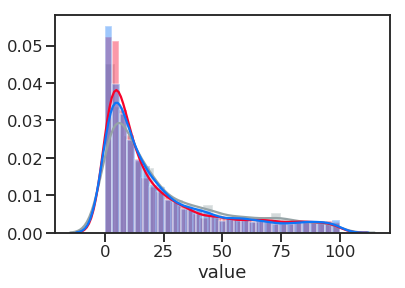

In [275]:
for n,g in rm_shuffle(cs).groupby("grp"):
    
    print(n)
    sns.distplot(g.value)

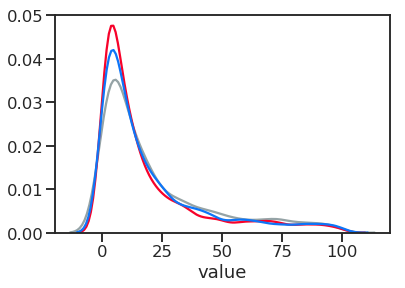

In [277]:
for n,g in just_session(cs).groupby("grp"):
    sns.distplot(g.value,hist=False)

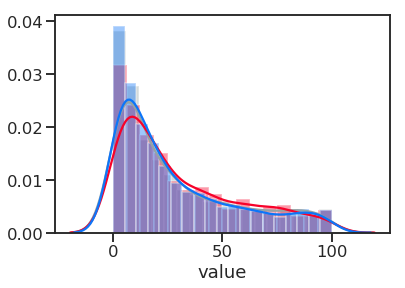

In [271]:
for n,g in just_day(cs).groupby("grp"):
    sns.distplot(g.value)

**Result:** most shifts are to close locations for session and day paired, as expected

# Remove day three reward cells

In [34]:
df = all_dfs_roi["pf_correlation"] # centroid shift cause cant get pop vec by roi
df = mjdplot.roi_to_label(df,col="first_roi")
df = just_session(df,shuffle=False)
#df = just_day(df,shuffle=False)


# import the roi labels (generated in reward notbook)
rois_sess3 = pd.read_pickle('day3-sess3-reward-rois.pkl')

# filtered dfs
df_filt_nr=df.query("roi_label not in @rois_sess3")
df_filt_rew=df.query("roi_label in @rois_sess3")

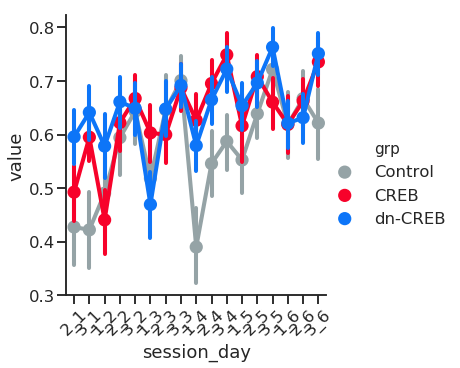

In [77]:
# all cells
g = sns.catplot(kind='point',data=df,x="session_day",y="value",hue="grp")
g.set_xticklabels(rotation=45)

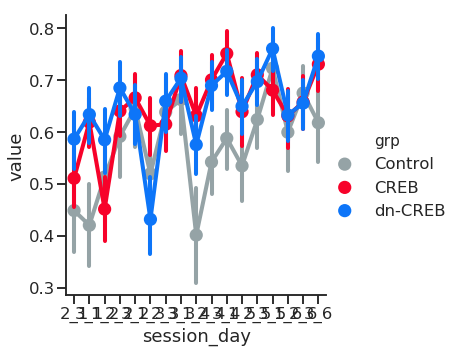

In [78]:
# remove reward cells from whole analysis
sns.catplot(kind='point',data=df_filt_nr,x="session_day",y="value",hue="grp")

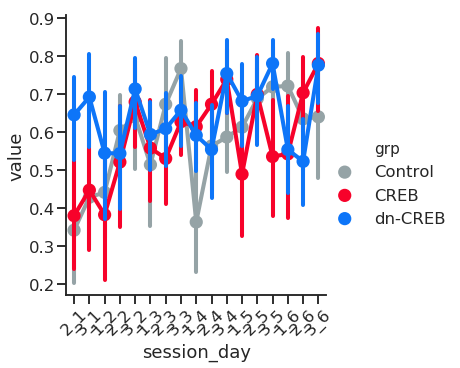

In [95]:
# just reward cells for d3s3, perhaps a bigger shift
g = sns.catplot(kind='point',data=df_filt_rew,x="session_day",y="value",hue="grp")
g.set_xticklabels(rotation=45)

In [55]:
# number of reward cells reward, across all animals
df_filt_rew.groupby(['grp','roi_label']).sum().reset_index().grp.value_counts()

CREB       74
dn-CREB    61
Control    55
Name: grp, dtype: int64

In [56]:
# total cell count 
df.groupby(['grp','roi_label']).sum().reset_index().grp.value_counts()

CREB       728
dn-CREB    507
Control    403
Name: grp, dtype: int64

### just sessions of interest
This will likely be in the paper

In [96]:
# just sessions of interest
df1 = df_filt_rew.query("session_day in ['3_3','1_4']").copy()
df1 = df1.assign(filter = 1)

df2 = df_filt_nr.query("session_day in ['3_3','1_4']").copy()
df2 = df2.assign(filter = 0)


dfm=pd.concat([df1,df2])

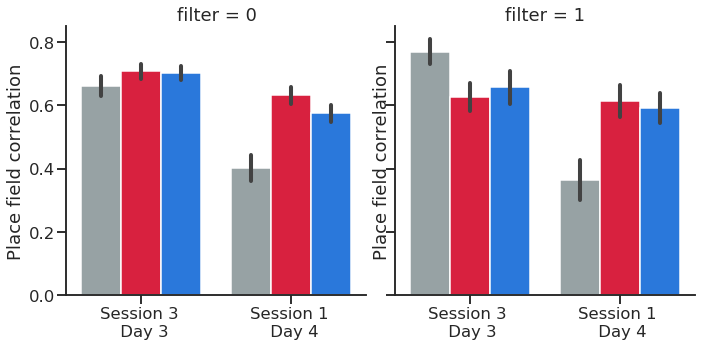

In [126]:
ax = sns.catplot(kind='bar',data=dfm,col ='filter',x="session_day",y="value",hue="grp",ci=68)
(ax.set(xlabel='', 
        ylabel='Place field correlation',
        xticklabels=["Session 3 \n Day 3","Session 1 \n Day 4"])
    ._legend.remove())

ax.savefig('figs/pf-corr-by-reward.svg')

In [101]:
%%R -i df1
# df1, just reward cells

am2 <-aov(value ~ (grp*session_day) + Error(mouseID/(session_day)), data = df1)
print(summary(am2))

/home/matt/anaconda2/lib/python2.7/site-packages/rpy2/robjects/pandas2ri.py:57: UserWarning: Error while trying to convert the column "first_expt". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'lab.classes.experiment.HiddenRewardExperiment'>'
  (name, str(e)))
/home/matt/anaconda2/lib/python2.7/site-packages/rpy2/robjects/pandas2ri.py:57: UserWarning: Error while trying to convert the column "second_roi". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'sima.ROI.ROI'>'
  (name, str(e)))



Error: mouseID
                Df Sum Sq Mean Sq F value Pr(>F)
grp              2 0.0268 0.01342   0.126  0.883
session_day      1 0.0083 0.00826   0.078  0.786
grp:session_day  2 0.0091 0.00456   0.043  0.958
Residuals       10 1.0623 0.10623               

Error: mouseID:session_day
                Df Sum Sq Mean Sq F value  Pr(>F)   
session_day      1  1.617  1.6173  10.543 0.00778 **
grp:session_day  2  1.901  0.9505   6.196 0.01577 * 
Residuals       11  1.688  0.1534                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: Within
           Df Sum Sq Mean Sq F value Pr(>F)
Residuals 243  26.05  0.1072               


In [115]:
for n,g in df1.groupby("session_day"):
    print('\n' + '='*10 + '\n' + 'GROUP: {}'.format(n) + '\n' + '='*10 + '\n')
    stats.full_anova(g,ind_vars=['grp'],dep_var='value')


GROUP: 1_4

# Formula: value~C(grp)
# grp: set(['Control', 'CREB', 'dn-CREB'])

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.069   
Dependent Variable: value            AIC:                105.1762
Date:               2019-12-02 13:20 BIC:                113.8697
No. Observations:   134              Log-Likelihood:     -49.588 
Df Model:           2                F-statistic:        5.931   
Df Residuals:       131              Prob (F-statistic): 0.00342 
R-squared:          0.083            Scale:              0.12554 
-----------------------------------------------------------------
                   Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.6145   0.0506 12.1406 0.0000  0.5144  0.7147
C(grp)[T.Control] -0.2505   0.0784 -3.1948 0.0018 -0.4056 -0.0954
C(grp)[T.dn-CREB] -0.0230   0.0712 -0.3225 0.7476 -0.1639  0.1179
------------

In [145]:
%%R -i df2
# df2, non reward cells
am2 <-aov(value ~ grp*session_day, data = df2)
print(summary(am2))

                 Df Sum Sq Mean Sq F value   Pr(>F)    
grp               2   2.02   1.011  10.043 5.00e-05 ***
session_day       1   3.38   3.384  33.607 1.02e-08 ***
grp:session_day   2   0.90   0.450   4.473   0.0117 *  
Residuals       706  71.10   0.101                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [138]:
%%R -i df2
# df2, non reward cells
am2 <-aov(value ~ (grp*session_day) + Error(mouseID/(session_day)), data = df2)
print(summary(am2))


Error: mouseID
                Df Sum Sq Mean Sq F value  Pr(>F)   
grp              2 2.0227  1.0114   9.686 0.00457 **
session_day      1 0.0414  0.0414   0.397 0.54286   
grp:session_day  2 1.5053  0.7526   7.208 0.01152 * 
Residuals       10 1.0441  0.1044                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: mouseID:session_day
                Df Sum Sq Mean Sq F value   Pr(>F)    
session_day      1  3.673   3.673  41.245 3.29e-05 ***
grp:session_day  2  0.733   0.367   4.115   0.0436 *  
Residuals       12  1.069   0.089                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: Within
           Df Sum Sq Mean Sq F value Pr(>F)
Residuals 681  67.32 0.09885               


In [139]:
for n,g in df2.groupby("session_day"):
    print('\n' + '='*10 + '\n' + 'GROUP: {}'.format(n) + '\n' + '='*10 + '\n')
    stats.full_anova(g,ind_vars=['grp'],dep_var='value')


GROUP: 1_4

# Formula: value~C(grp)
# grp: set(['Control', 'CREB', 'dn-CREB'])

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.055   
Dependent Variable: value            AIC:                270.9497
Date:               2019-12-04 12:59 BIC:                282.6576
No. Observations:   366              Log-Likelihood:     -132.47 
Df Model:           2                F-statistic:        11.55   
Df Residuals:       363              Prob (F-statistic): 1.37e-05
R-squared:          0.060            Scale:              0.12176 
-----------------------------------------------------------------
                   Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.6307   0.0293 21.5402 0.0000  0.5732  0.6883
C(grp)[T.Control] -0.2297   0.0484 -4.7453 0.0000 -0.3248 -0.1345
C(grp)[T.dn-CREB] -0.0557   0.0414 -1.3443 0.1797 -0.1371  0.0258
------------

# Combined DF

## by expt

In [67]:
from copy import copy

In [133]:
key = "pop_vector"

all_dfs_temp = copy(all_dfs)

df_comb=all_dfs_temp.pop(key)
df_comb.rename(columns = {'value':key},inplace=True)

for key,df in all_dfs_temp.items():
    
    df.rename(columns = {'value':key},inplace=True)
    
    df_comb = pd.merge(df_comb,df,on=["grp","pairing","trial_id"],suffixes=["",key])
    
df_comb = rm_shuffle(df_comb)
df_comb.trial_id = df_comb.trial_id.astype('int64') # for merge later

df_comb = df_comb.loc[:,[ 'grp', 'pairing', 'trial_id', 'condition', 'day', 'session','pop_vector','recurrence','centroid_shift','pf_correlation','experimentType','startTime','mouseID', u'session_day']]

df_comb.columns = df_comb.columns.str.rstrip('_x')

In [137]:
# reward combine
df_csv = pd.read_csv('big-df-by-expt.csv')
df_merge = pd.merge(df_comb,df_csv,on=["grp","trial_id"],suffixes=["",key]) # delete y 
df_merge = add_mouse_kind(df_merge)

df_merge.head()

,grp,pairing,trial_id,condition,day,session,pop_vector,recurrence,centroid_shift,pf_correlation,...,fraction_near_rads_8,fraction_near_norm_05,fraction_near_norm_10,lick_reward_fraction,anticipatory_licking,activity_centroid_reward_distance,centroid_reward_distance,pc_percentage,spatial_information_pc,circular_variance_pc
0,Control,session,12816,1,1,2,0.234319,0.640000,45.148366,0.247409,...,0.095238,0.166667,0.238095,0.261380,0.416406,1.673903,0.227637,0.315789,1.457080,0.389144
1,Control,session,12836,1,1,2,0.461335,0.500000,29.583319,0.482900,...,0.200000,0.040000,0.320000,0.264398,0.434286,1.496164,0.206785,0.245098,0.737252,0.561421
2,Control,session,12809,1,1,3,0.213873,0.690476,44.896778,0.078540,...,0.111111,0.066667,0.266667,0.417450,0.735537,1.330807,0.195359,0.338346,1.611223,0.257571
3,Control,session,12823,1,1,3,0.476591,0.640000,39.481112,0.450079,...,0.137931,0.137931,0.448276,0.194004,0.352662,1.481059,0.172857,0.284314,1.218589,0.477369
4,Control,session,12841,1,2,1,0.400350,0.655172,39.852720,0.418482,...,0.093750,0.062500,0.250000,0.215323,0.515277,1.655633,0.236879,0.313725,1.263194,0.430771


In [ ]:
df_merge.to_csv('big-df-by-expt-with-stab.csv')

## merge ROI

# add mouse kind codes

In [166]:
def add_mouse_kind(df):
    """Puts mouse type for CREB exp in df"""

    nmap = {'mjd503':"CaMKII mouse",
            'mjd500':"CaMKII mouse",
            'mjd511':"CaMKII mouse",
            'mjd535':"AAV CaMKII",
            'mjd537':"AAV CaMKII",
            'mjd016':"AL lab",        
            'mjd017':"AL lab",
            'mjd529':"AAV CaMKII",
            'mjd532':"AAV CaMKII",
            'mjd533':"AAV CaMKII",
            'mjd534':"AAV CaMKII",
            'mjd012':"AL lab",
            'mjd505':"CaMKII mouse",
            'mjd527':"AAV CaMKII",
            'mjd528':"AAV CaMKII",
            'mjd526':"AAV CaMKII"}

    df["mouse_kind"] = df.mouseID.apply(lambda x: nmap[x] )
    
    
    return df




## by roi

In [27]:
# remove non roi measures
all_dfs_roi.pop("recurrence")
all_dfs_roi.pop('pop_vector')

,index,first_expt,position_bin_index,value,grp,pairing,trial_id,condition,day,session,experimentType,startTime,mouseID,session_day
0,0,[[]],0,0.460589,Control,session,12869,1,1,2,hiddenRewards,2017-12-09-17h30m39s,mjd511,2_1
1,1,[[]],1,0.388913,Control,session,12869,1,1,2,hiddenRewards,2017-12-09-17h30m39s,mjd511,2_1
2,2,[[]],2,0.367889,Control,session,12869,1,1,2,hiddenRewards,2017-12-09-17h30m39s,mjd511,2_1
3,3,[[]],3,0.391119,Control,session,12869,1,1,2,hiddenRewards,2017-12-09-17h30m39s,mjd511,2_1
4,4,[[]],4,0.415500,Control,session,12869,1,1,2,hiddenRewards,2017-12-09-17h30m39s,mjd511,2_1
5,5,[[]],5,0.384183,Control,session,12869,1,1,2,hiddenRewards,2017-12-09-17h30m39s,mjd511,2_1
6,6,[[]],6,0.316312,Control,session,12869,1,1,2,hiddenRewards,2017-12-09-17h30m39s,mjd511,2_1
7,7,[[]],7,0.250320,Control,session,12869,1,1,2,hiddenRewards,2017-12-09-17h30m39s,mjd511,2_1
8,8,[[]],8,0.194483,Control,session,12869,1,1,2,hiddenRewards,2017-12-09-17h30m39s,mjd511,2_1
9,9,[[]],9,0.142659,Control,session,12869,1,1,2,hiddenRewards,2017-12-09-17h30m39s,mjd511,2_1


In [28]:
key = "centroid_shift"

df_comb = all_dfs_roi.pop(key)
df_comb = mjdplot.roi_to_label(df_comb,col="first_roi")
df_comb.rename(columns = {'value':key},inplace=True)

for key,df in all_dfs_roi.items():
    df = just_session(df) # NEEDED FOR BIG ROI DF???
        
    df  = mjdplot.roi_to_label(df,col="first_roi")    
    
    df.rename(columns = {'value':key},inplace=True)
    
    df_comb = pd.merge(df_comb,df,on=["grp","trial_id","first_roi"],suffixes=['', '_y'])

df_comb.trial_id = df_comb.trial_id.astype('int64') # for merge later

In [29]:
df_rew = pd.read_csv('big-df-by-roi.csv')
df_rew.rename(columns = {'expt_grp':'grp'}, inplace = True)

In [30]:
df_comb.columns

Index([u'index', u'first_expt', u'first_roi', u'second_roi', u'first_centroid',
       u'second_centroid', u'centroid_shift', u'grp', u'pairing', u'trial_id',
       u'condition', u'day', u'session', u'experimentType', u'startTime',
       u'mouseID', u'session_day', u'roi_label', u'index_y', u'first_expt_y',
       u'second_roi_y', u'pf_correlation', u'pairing_y', u'condition_y',
       u'day_y', u'session_y', u'experimentType_y', u'startTime_y',
       u'mouseID_y', u'session_day_y', u'roi_label_y'],
      dtype='object')

In [33]:
df_merge = pd.merge(df_comb,df_rew,on=["grp","trial_id","roi_label"],suffixes=['', '_z'])
df_merge

,index,first_expt,first_roi,second_roi,first_centroid,second_centroid,centroid_shift,grp,pairing,trial_id,...,fraction_near_norm_10,activity_centroid_reward_distance_pc_only,centroid_reward_distance,condition_z,day_z,session_z,experimentType_z,startTime_z,session_day_z,reward
0,0,[[]],<ROI: label=R0000-0090-0014>,<ROI: label=R0000-0090-0014>,(0.6271749948636509-0.4606384810300576j),(-0.5287395667786025+0.26759662960701175j),94.667423,Control,session,12869,...,1.0,0.253662,0.032559,1,1,2,hiddenRewards,2017-12-09-17h30m39s,2_1,In
1,1,[[]],<ROI: label=R0000-0065-0037>,<ROI: label=R0000-0065-0037>,(-0.0041078577995113585-0.02286209743512468j),(0.3056204305793952-0.3644056635796064j),27.893434,Control,session,12869,...,0.0,2.993132,0.477288,1,1,2,hiddenRewards,2017-12-09-17h30m39s,2_1,Out
2,2,[[]],<ROI: label=R0000-0100-0210>,<ROI: label=R0000-0100-0210>,(0.24525626317902072+0.2838262177103739j),(0.02247165516455577+0.14679213340362213j),17.840635,Control,session,12869,...,0.0,1.000359,0.179369,1,1,2,hiddenRewards,2017-12-09-17h30m39s,2_1,Out
3,3,[[]],<ROI: label=R0000-0074-0072>,<ROI: label=R0000-0074-0072>,(0.09570347613695786+0.3376464328596677j),(-0.09492576176537726+0.48357313780288175j),14.930193,Control,session,12869,...,0.0,0.655079,0.152786,1,1,2,hiddenRewards,2017-12-09-17h30m39s,2_1,Out
4,4,[[]],<ROI: label=R0000-0040-0003>,<ROI: label=R0000-0040-0003>,(-0.8264056252782699+0.08451856056767397j),(-0.7598388293592226-0.07800834110671215j),6.534882,Control,session,12869,...,1.0,0.824397,0.090230,1,1,2,hiddenRewards,2017-12-09-17h30m39s,2_1,In
5,5,[[]],<ROI: label=R0000-0015-0180>,<ROI: label=R0000-0015-0180>,(0.35899871541049544-0.2796877213381773j),(0.6411867147373623-0.5384606053077557j),1.423644,Control,session,12869,...,0.0,3.141593,0.481119,1,1,2,hiddenRewards,2017-12-09-17h30m39s,2_1,Out
6,6,[[]],<ROI: label=R0000-0047-0134>,<ROI: label=R0000-0047-0134>,(-0.7334788161345304-0.3657323289328856j),(-0.9133752530284528+0.12279585481243387j),19.004562,Control,session,12869,...,1.0,0.588093,0.091410,1,1,2,hiddenRewards,2017-12-09-17h30m39s,2_1,In
7,7,[[]],<ROI: label=R0000-0088-0220>,<ROI: label=R0000-0088-0220>,(-0.9862810861278763-0.05686227813360137j),(-0.974850541071591+0.011051441063166394j),2.013504,Control,session,12869,...,0.0,0.710555,0.113565,1,1,2,hiddenRewards,2017-12-09-17h30m39s,2_1,Out
8,8,[[]],<ROI: label=R0000-0052-0147>,<ROI: label=R0000-0052-0147>,(-0.6145824398784783-0.2101162961692077j),(-0.5553361717029028+0.3482332462500144j),28.305487,Control,session,12869,...,1.0,0.161420,0.041138,1,1,2,hiddenRewards,2017-12-09-17h30m39s,2_1,In
9,9,[[]],<ROI: label=R0000-0089-0166>,<ROI: label=R0000-0089-0166>,(0.6934562124073335-0.3802315633728337j),(0.6271278226807798-0.27682217680036436j),2.848000,Control,session,12869,...,0.0,2.833785,0.274567,1,1,2,hiddenRewards,2017-12-09-17h30m39s,2_1,Out


In [41]:
df_merge.shape


(7855, 71)

In [51]:
df_merge = add_ss_col(df_merge)

In [50]:
def add_ss_col(df,threshold = 1.75 ,col_name="ss"):
    df.loc[df.eval('spatial_information < @threshold'), col_name] = "low"
    df.loc[df.eval('spatial_information > @threshold'), col_name] = "high"
    return df

## test

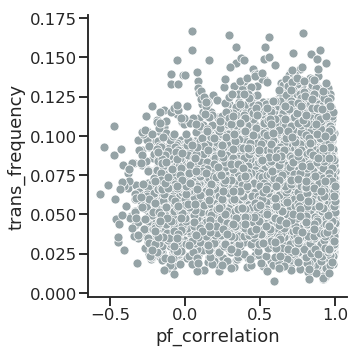

In [40]:
sns.relplot(x='pf_correlation',
            y='trans_frequency',kind='scatter',data=df_merge)

# weakly tuned cells

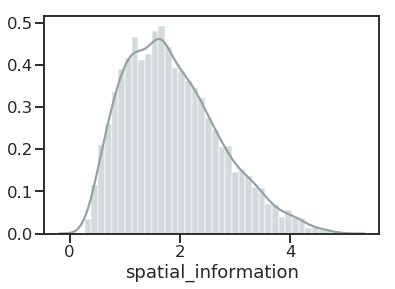

In [47]:
sns.distplot(df_merge.spatial_information)

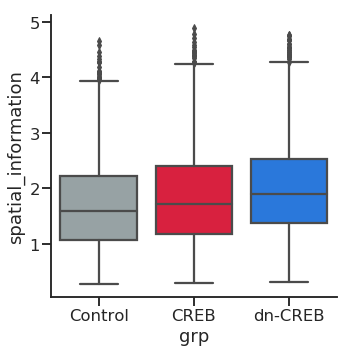

In [49]:
sns.catplot(data = df_merge, x = "grp", y = "spatial_information", kind="box")

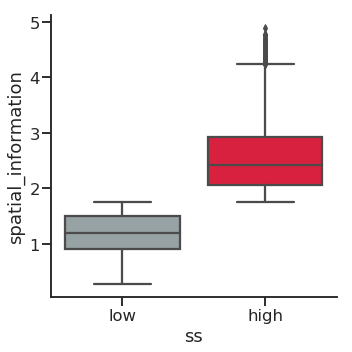

In [54]:
## just to show the split worked
sns.catplot(data = df_merge, x = "ss", y = "spatial_information", kind="box")

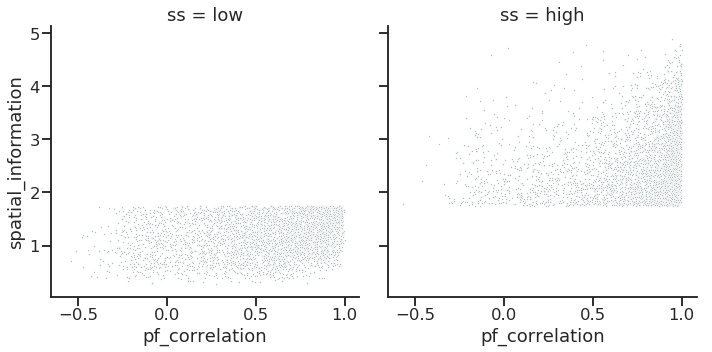

In [58]:
sns.relplot(data = df_merge, x = "pf_correlation", y = "spatial_information", col = "ss", kind="scatter", s =3)



### day 1

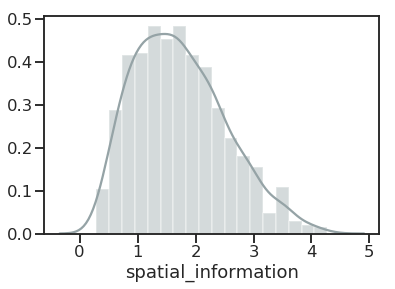

In [64]:
df_d1 = df_merge.query("day == '1'")

sns.distplot(df_d1.spatial_information)

### see counts of time pc

In [66]:
# just d1
df_d1.groupby("roi_label").count()

,index,first_expt,first_roi,second_roi,first_centroid,second_centroid,centroid_shift,grp,pairing,trial_id,...,activity_centroid_reward_distance_pc_only,centroid_reward_distance,condition_z,day_z,session_z,experimentType_z,startTime_z,session_day_z,reward,ss
roi_label,,,,,,,,,,,,,,,,,,,,,
R0000-0003-0133,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
R0000-0003-0218,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
R0000-0004-0122,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
R0000-0005-0091,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
R0000-0005-0102,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
R0000-0005-0108,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
R0000-0005-0220,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
R0000-0005-0236,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
R0000-0006-0021,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


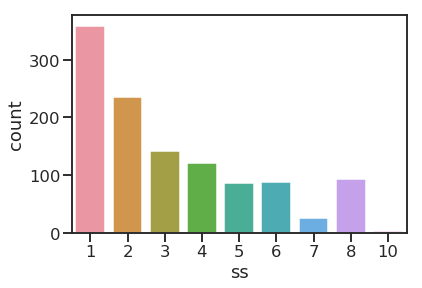

In [89]:
cnts = df_merge.query("day in ['1','2','3']").groupby("roi_label").count()

sns.countplot(cnts.ss)

In [107]:
df_8s_cells = df_merge.query("day in ['1','2','3']").groupby("roi_label").filter(lambda x: len(x) ==8)

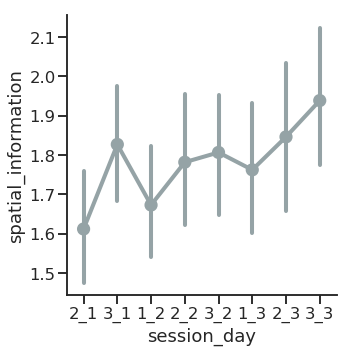

In [108]:
sns.catplot(kind='point',data=df_8s_cells,x = 'session_day',y = 'spatial_information')

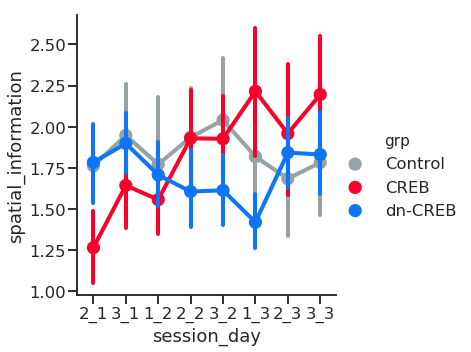

In [118]:
sns.catplot(kind='point',data=df_8s_cells,x = 'session_day',y = 'spatial_information',hue='grp')

**Result:** seems spatial info increase is driven by CREB, in 8 session cell; not seeing the guo2020 effect of strengthen pc, may need to separate weak initial tuning

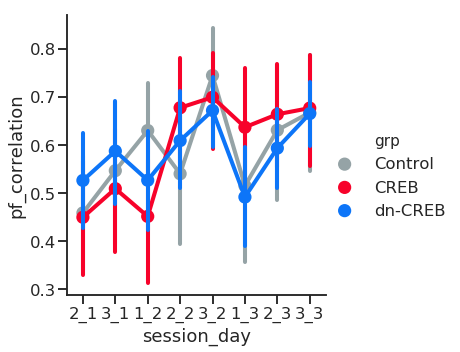

In [110]:
sns.catplot(kind='point',data=df_8s_cells,x = 'session_day',y = 'pf_correlation',hue='grp')

### session 1 counts of weak vs strong tuned cells

In [133]:
df_s1 = df_rew.query("session=='1' and day =='1'").dropna()

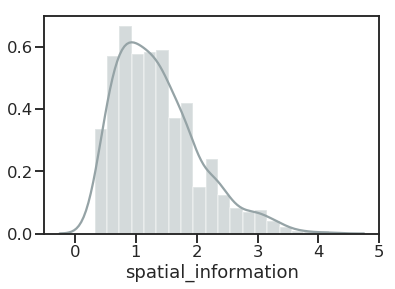

In [134]:
sns.distplot(df_s1.spatial_information)

In [251]:
df_s1=  add_ss_col(df_s1,threshold = 1)

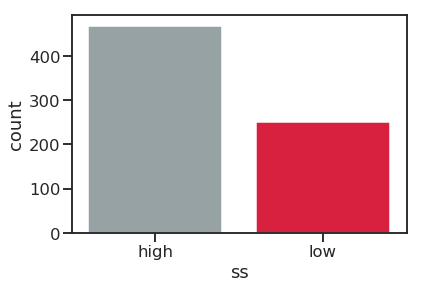

In [252]:
sns.countplot(df_s1.ss)

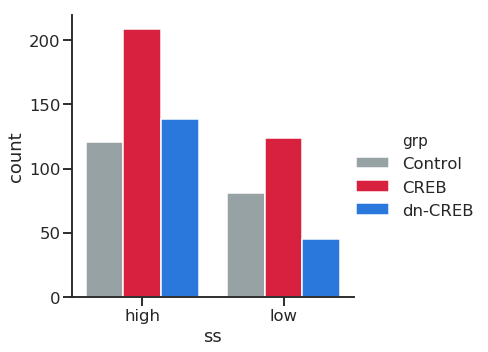

In [253]:
sns.catplot(kind="count",x="ss",hue="grp",data = df_s1)

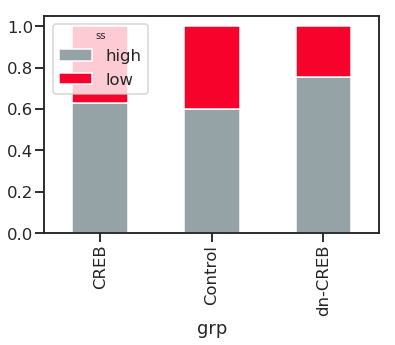

In [254]:
props = df_s1.groupby("grp")['ss'].value_counts(normalize=True).unstack()
props.plot(kind='bar', stacked='True')

**Result:** does look the ratio, controls have more weak tuned cells on 1st session than the other, especially dn-CREB

### ws across days

In [255]:
ws_rois = df_s1.query("ss=='low'").roi_label
df_ws = df_rew.query("roi_label in @ws_rois.values")


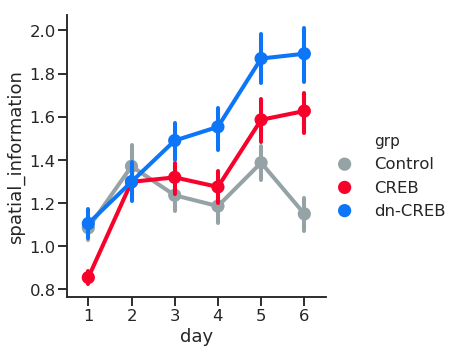

In [256]:

sns.catplot(x='day',y="spatial_information", hue='grp',
            data=df_ws,
                kind="point", ci=68)

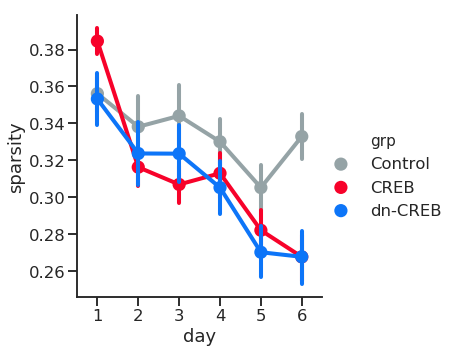

In [160]:
sns.catplot(x='day',y="sparsity", hue='grp',
            data=df_rew.query("roi_label in @ws_rois.values"),
                kind="point", ci=68)

### strong cells

In [220]:
ss_rois = df_s1.query("ss=='high'").roi_label
df_ss = df_rew.query("roi_label in @ss_rois.values")


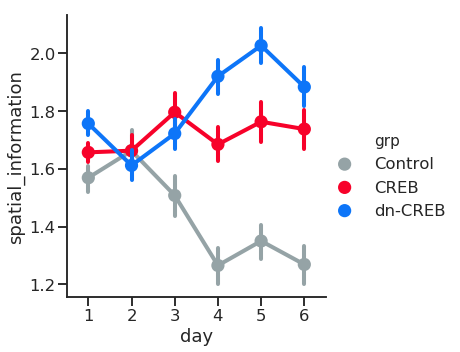

In [222]:

sns.catplot(x='day',y="spatial_information", hue='grp',
            data=df_ss,
                kind="point", ci=68)

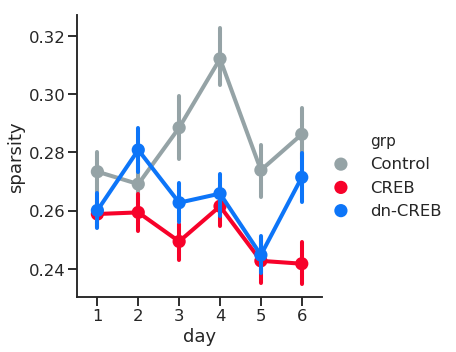

In [161]:
sns.catplot(x='day',y="sparsity", hue='grp',
            data=df_ss,
                kind="point", ci=68)

### ws session 1, but recurs for many sessions

**weak**

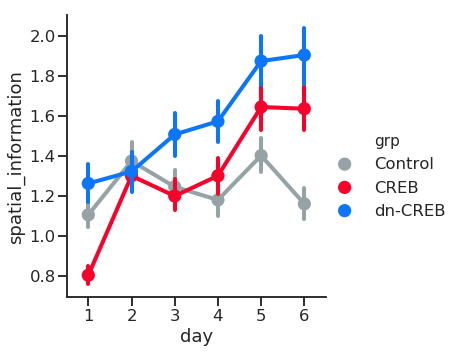

In [226]:
ws_8s = set(df_ws.groupby("roi_label").filter(lambda x: len(x) >8).roi_label)

sns.catplot(x='day',y="spatial_information", hue='grp',
            data=df_rew.query("roi_label in @ws_8s"),
                kind="point", ci=68)

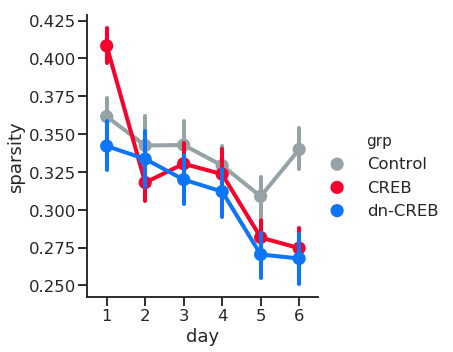

In [236]:
sns.catplot(x='day',y="sparsity", hue='grp',
            data=df_rew.query("roi_label in @ws_8s"),
                kind="point", ci=68)

**strong**

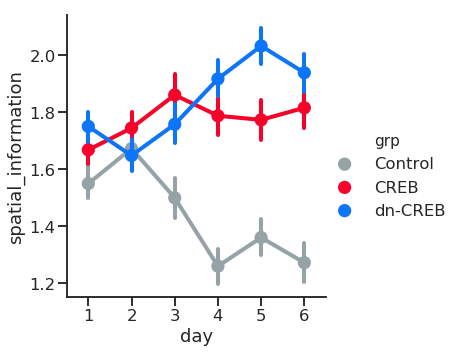

In [233]:
ws_8s = set(df_ss.groupby("roi_label").filter(lambda x: len(x) >8).roi_label)

sns.catplot(x='day',y="spatial_information", hue='grp',
            data=df_rew.query("roi_label in @ws_8s"),
                kind="point", ci=68)

In [219]:
# get some counts
df_ws.groupby("roi_label").filter(lambda x: len(x) >8).groupby(["grp","day"]).count()

Unnamed: 0   pc  sensitivity  specificity  sparsity  pf_width  \
grp     day                                                                  
CREB    1           105  105           92           94       104        94   
        2            96   96           82           84        96        84   
        3           102  102           87           88       101        88   
        4            82   82           64           67        82        67   
        5            75   75           68           68        75        68   
        6            74   74           67           67        74        67   
Control 1           136  136          125          127       136       127   
        2            96   96           78           79        96        79   
        3           109  109           77           81       108        81   
        4           120  120           86           88       120        88   
        5           108  108           87           89       106        89   
        6           119  119           81           82       117        82   
dn-CREB 1            55   55           52           52        55        52   
        2            48   48           41           43        48        43   
        3            52   52           47           48        52        48   
        4            50   50           47           47        50        47   
        5            53   53           51           51        53        51   
        6            52   52           50           50        52        50   

             trans_auc  trans_amplitude  trans_duration  trans_frequency  ...  \
grp     day                                                               ...   
CREB    1          105              105             105              105  ...   
        2           96               96              96               96  ...   
        3          102              101             101              102  ...   
        4           82               81              81               82  ...   
        5           75               75              75               75  ...   
        6           74               74              74               74  ...   
Control 1          136              136             136              136  ...   
        2           96               96              96               96  ...   
        3          109              109             109              109  ...   
        4          120              120             120              120  ...   
        5          108              107             107              108  ...   
        6          119              118             118              119  ...   
dn-CREB 1           55               55              55               55  ...   
        2           48               48              48               48  ...   
        3           52               52              52               52  ...   
        4           50               50              50               50  ...   
        5           53               53              53               53  ...   
        6           52               52              52               52  ...   

             activity_centroid_reward_distance_pc_only  \
grp     day                                              
CREB    1                                           94   
        2                                           84   
        3                                           88   
        4                                           67   
        5                                           68   
        6                                           67   
Control 1                                          127   
        2                                           79   
        3                                           81   
        4                                           88   
        5                                           89   
        6                                           82   
dn-CREB 1          

### **Result:** 
* seems 1st session weak cells rise in CREB and dn-CREB; not controls.
* ss are stable, but controls actually decrease

In [237]:
df_rew.columns

Index([u'Unnamed: 0', u'pc', u'grp', u'sensitivity', u'specificity',
       u'sparsity', u'pf_width', u'trans_auc', u'trans_amplitude',
       u'trans_duration', u'trans_frequency', u'trans_auc_nr',
       u'trans_amplitude_nr', u'trans_duration_nr', u'trans_frequency_nr',
       u'trans_auc_all', u'trans_amplitude_all', u'trans_duration_all',
       u'trans_frequency_all', u'circ_var', u'circ_var_p',
       u'spatial_information', u'angle', u'length', u'activity_centroid',
       u'n_place_fields', u'distance_x', u'fraction_near_rads_8',
       u'distance_y', u'fraction_near_norm_05', u'distance',
       u'fraction_near_norm_10', u'activity_centroid_reward_distance_pc_only',
       u'centroid_reward_distance', u'trial_id', u'condition', u'day',
       u'session', u'experimentType', u'startTime', u'session_day',
       u'roi_label', u'reward'],
      dtype='object')

## reward and stability

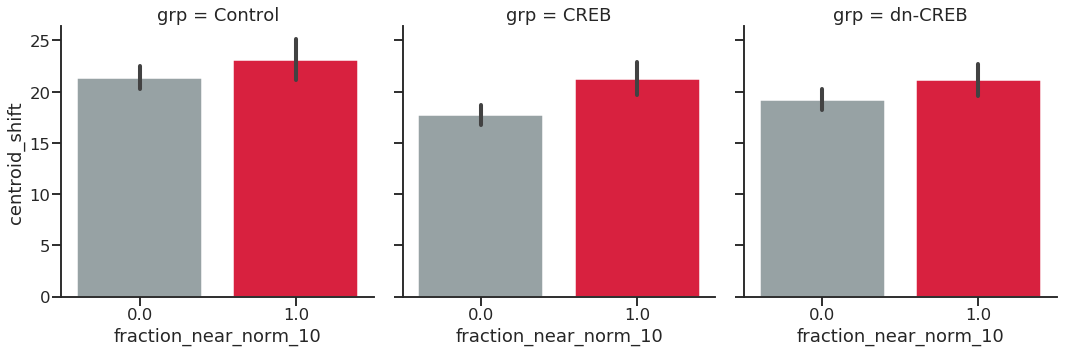

In [42]:
sns.catplot(x='fraction_near_norm_10',col='grp',
            y='centroid_shift',kind='bar',data=df_merge)

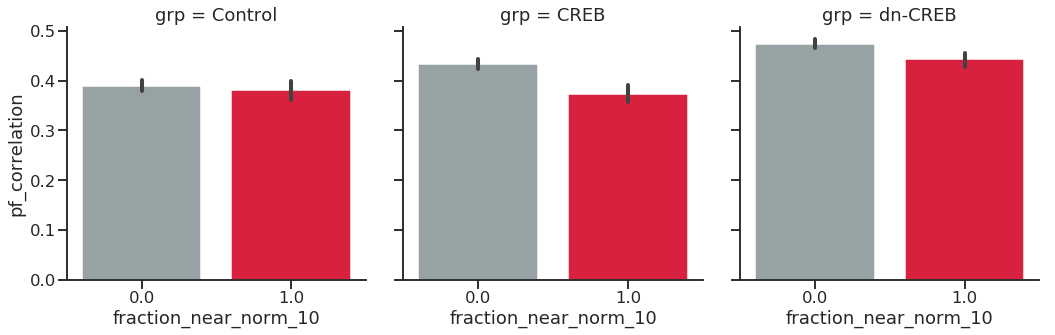

In [64]:
sns.catplot(x='fraction_near_norm_10',col='grp',
            y='pf_correlation',kind='bar',data=df_merge,ci=68)

In [44]:
df_agg= df_merge.groupby(["grp","mouseID","fraction_near_norm_10"]).mean().reset_index()

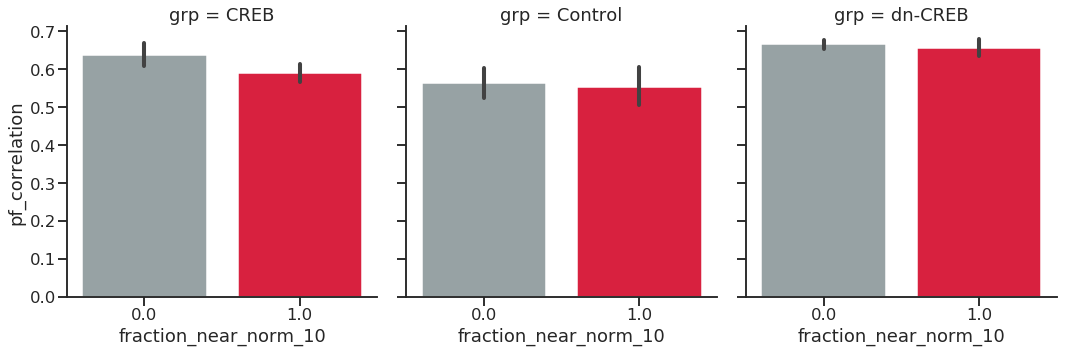

In [45]:
sns.catplot(x='fraction_near_norm_10',col='grp',
            y='pf_correlation',kind='bar',data=df_agg,ci=68)

## plotting combined

<Figure size 720x720 with 0 Axes>

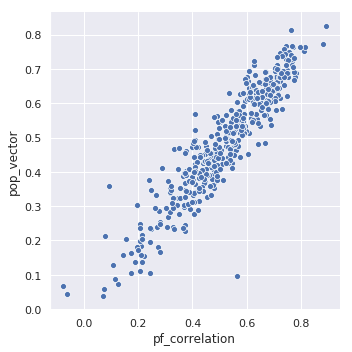

In [88]:
sns.relplot(x='pf_correlation',
            y='pop_vector',kind='scatter',data=df_comb)

<Figure size 720x720 with 0 Axes>

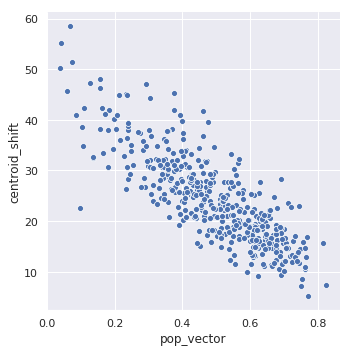

In [91]:
plt.figure(figsize=(10,10))
sns.relplot(x='pop_vector',
            y='centroid_shift',kind='scatter',data=df_comb)

<Figure size 720x720 with 0 Axes>

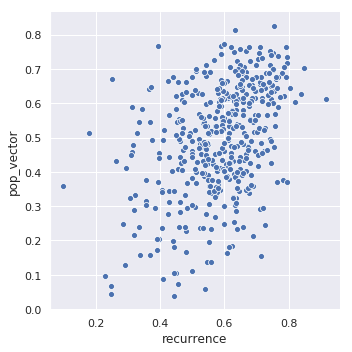

In [89]:
expt_grpplt.figure(figsize=(10,10))
sns.relplot(x='recurrencplt.figure(figsize=(10,10))
sns.relplot(x='recurrence',
            y='pop_vector',kind='scatter',data=df_comb)e',
            y='pop_vector',kind='scatter',data=df_comb)

## plotting merge

<Figure size 720x720 with 0 Axes>

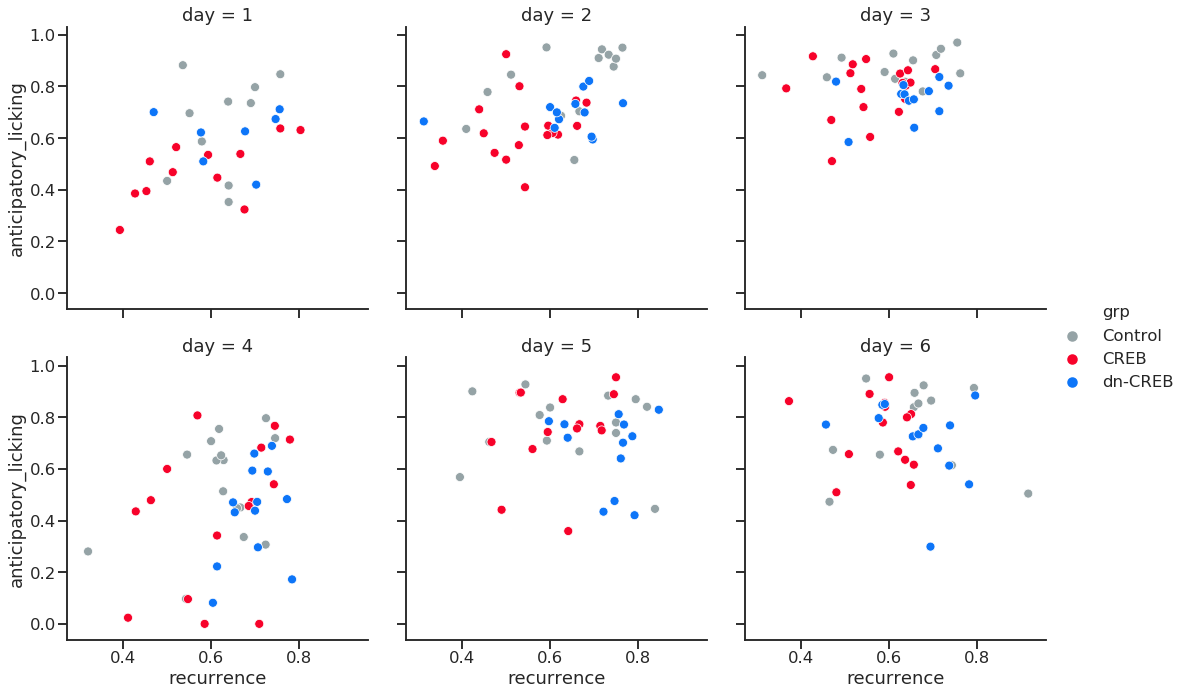

In [141]:
plt.figure(figsize=(10,10))
sns.relplot(data=just_session(df_merge),x='recurrence',
            y='anticipatory_licking',hue='grp',col='day',col_wrap=3,kind='scatter',)

# PAIRING + DATA ***~DONT NEED AFTER PKL~***


## pair data

In [6]:
# pairing

# session
session_paired = [
        grp.pair('consecutive groups',
                 groupby=['X_condition', 'X_day', 'X_session'])
        for grp in exptGrps]

# day
day_paired = [grp.pair('same group', groupby=['X_session']).pair(
        'consecutive groups', groupby=['X_condition', 'X_day']) for grp in
        exptGrps]

paired_exptGrps=[session_paired, day_paired]

In [278]:
# 2020 
#all experiments within condition
paired_grps = [grp.pair(
        'same group', groupby=['condition']) for grp in exptGrps]

NameError: name 'exptGrps' is not defined

## check pairing

In [191]:
# check pairing
plist =[]
for grp in day_paired:
    for e1, e2 in grp.genImagedExptPairs():
        plist.append((e1.parent.get('mouseID'),e1.get('day'),e1.get('session'),
             e2.parent.get('mouseID'),e2.get('day'),e2.get('session')))
        
# tried to iterate over pairs to find in df, prob dont need 
#for r in plist:
#    print(df_mid.value[(df_mid.mouseID==r[0]) & (df_mid.day==r[1]) & (df_mid.session==r[2])])
    

## generate data

Plotting of place_field_correlation failed
Unrecognized column name: roi
pf_correlation
Plotting of place_field_correlation failed
Unrecognized column name: roi
pf_correlation


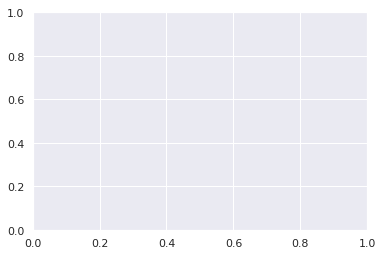

In [22]:
# generate data
data_dicts_both=[]

#groupby = (('second_expt',),)
groupby = (('roi',),)
pc_pairing = 'pc_either' # 'pc_either'
circ_var_pcs = False
fig,ax = plt.subplots(1)

"""
keys=['recurrence',
      'pf_correlation',
      'centroid_shift',
      'pop_vector']

metrics={'recurrence': place.recurrence_probability,
         'pf_correlation': place.place_field_correlation,
         'centroid_shift': place.activity_centroid_shift,
         'pop_vector':place.population_vector_correlation}
"""
keys=['pf_correlation']

metrics={'pf_correlation': place.place_field_correlation}

activity_kwargs= {'recurrence': None,
                  'pf_correlation': {'activity_filter': pc_pairing},
                  'centroid_shift': {'activity_filter': pc_pairing,
                                     'circ_var_pcs': circ_var_pcs,
                                     'units': 'cm'},
                  'pop_vector': {'method': 'corr', 
                                 'activity_filter': pc_pairing, 
                                 'min_pf_density': 0.05,
                                 'circ_var_pcs': circ_var_pcs}}

activity_labels = ['Recurrence probability',
                  'Place field correlation',
                  'Centroid shift (cm)',
                  'Population vector correlation']

for pair in paired_exptGrps:
    data={}
    for key in keys:
        data[key]=plot_metric(
                ax=ax, exptGrps=pair, roi_filters=roi_filters,
                metric_fn=metrics[key], plot_method='grouped_bar',
                groupby=groupby, plotby=None, activity_kwargs=activity_kwargs[key],
                pool_shuffle=True,plot_shuffle=True)
        print(key)
        
    data_dicts_both.append(data)

## create dataframe

In [24]:
# dataframe from data
data_dicts = data_dicts_both
all_dfs={}

for key in keys:
    dfs=[]
    for d,s in zip(data_dicts,['session','day']):
        df = stats.prep_data(d[key])
        df["pairing"] = s
        dfs.append(df)
    cdf = pd.concat(dfs)
    
    # clean & expand expt
    #cdf = cdf.rename(columns = {"second_expt": "expt"})
    cdf = mjdplot.attrib_to_df(cdf,drop_expt=False).reset_index()
    all_dfs.update({key:cdf})
    
    
#mjdhelp.save_pickle(all_dfs,'stability-just-pf-corr-PCeither-for-expt-objects.pkl')

# Single plot - Day vs Session

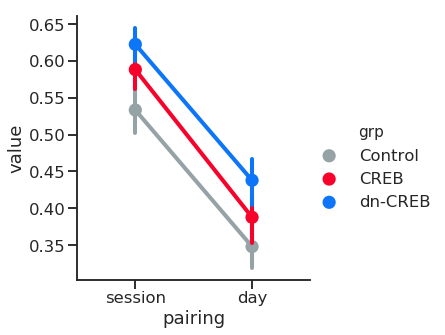

In [23]:
key = 'pop_vector'

sns.catplot(x='pairing',y="value", hue='grp',
            kind="point",data=rm_shuffle(all_dfs[key]))

# Individual mouse plots

In [120]:
key = 'pop_vector'
dfs = all_dfs[key]
dfs.groupby('pairing').count()

,index,position_bin_index,value,grp,trial_id,condition,day,session,experimentType,startTime,mouseID,session_day
pairing,,,,,,,,,,,,
day,420,420,420,420,420,420,420,420,420,420,420,420
session,476,476,476,476,476,476,476,476,476,476,476,476


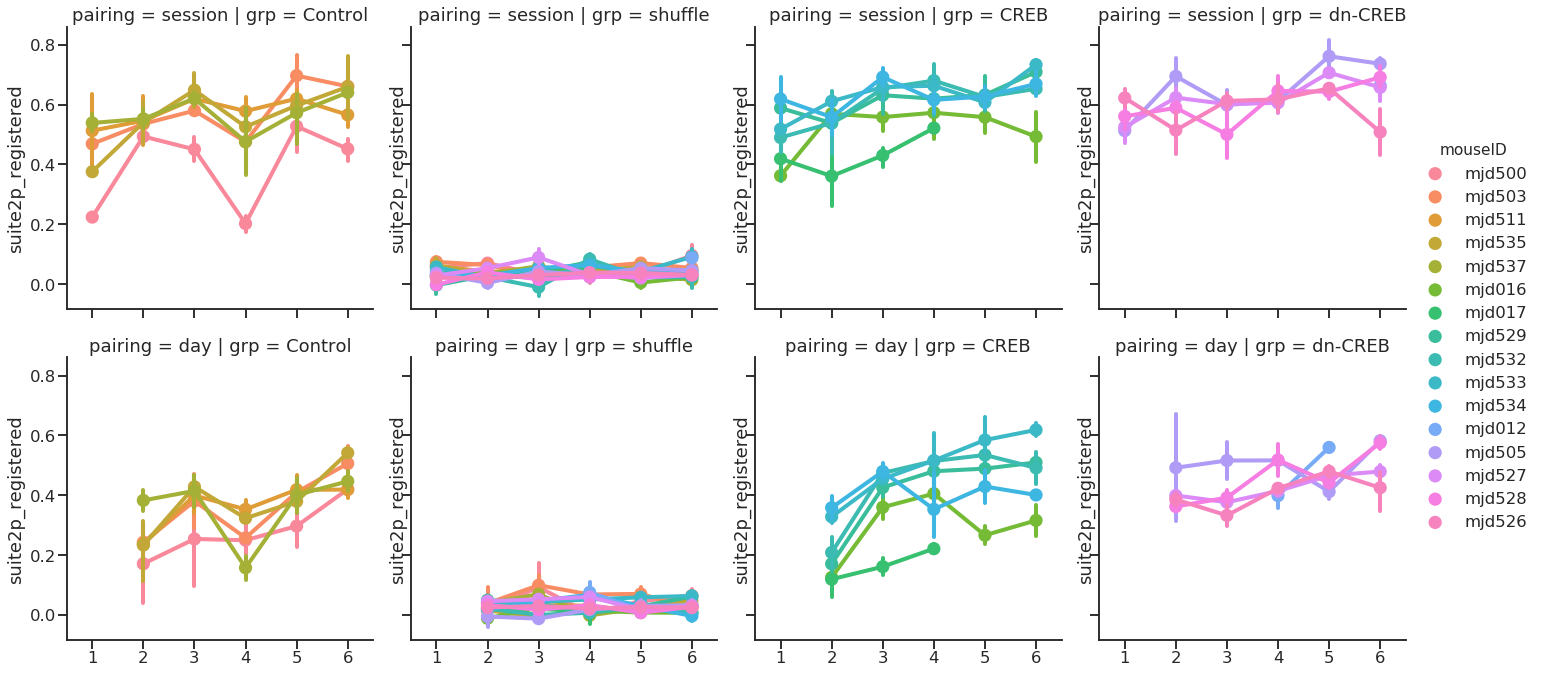

In [121]:
ax = sns.catplot(x='day',y="value", hue='mouseID', col = "grp",row='pairing',
                kind="point",data=dfs,ci=68)
     
ax.set(xlabel='', ylabel=label)
sns.despine()

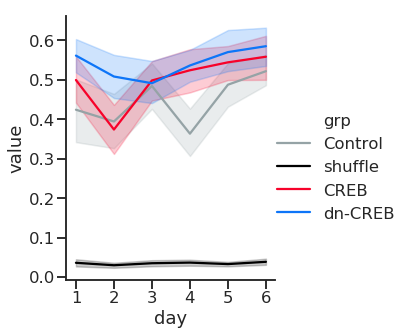

In [132]:
p=['#95a3a6', '#000000', '#f7022a', '#0d75f8']
g = sns.relplot(x='day',y="value", hue = "grp",
                kind="line",data=deepcopy(all_dfs[key]),
                height=height, aspect=width/height,palette = p)
g.savefig('figs/for-legend.svg')

 # Pop vector

## key select

In [6]:
print(all_dfs.keys())

key = 'pop_vector'
key_label = 'Population vector correlation'

# select key
df = deepcopy(all_dfs[key])
df,df_shuffle = just_day(df,shuffle=True)


['recurrence', 'pf_correlation', 'pop_vector', 'centroid_shift']


## pop vector overall

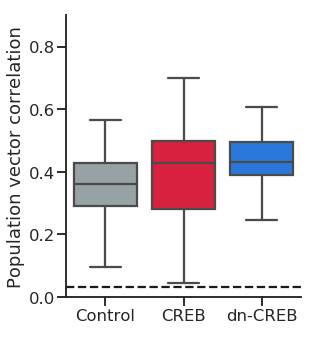

In [7]:
height,width = 5., 4.5
#fig = plt.figure(figsize=(2,5))
#ax = sns.boxplot(x="grp",y="value",data=df,showfliers=False)

g = sns.catplot(x='grp',y="value",
                kind="box",data=df,showfliers=False,
                height=height, aspect=width/height)

# axis
g.set(ylim=(0,.9),ylabel=key_label,xlabel=' ')
sns.despine()

# legend


# shuffle
g.ax.axhline(df_shuffle.value.mean(), linestyle='--', color='k')

# save
#g.savefig('figs/popvec-overall-dpair-pcboth.svg')

In [29]:
%%R -i df
am2 <-aov(value ~ grp, data = df)

print(summary(am2))
TukeyHSD(am2)

             Df Sum Sq Mean Sq F value  Pr(>F)   
grp           2  0.266 0.13297   6.953 0.00119 **
Residuals   208  3.978 0.01912                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = value ~ grp, data = df)

$grp
                      diff          lwr        upr     p adj
CREB-Control    0.03980368 -0.014042552 0.09364991 0.1910482
dn-CREB-Control 0.09007536  0.032988683 0.14716205 0.0007339
dn-CREB-CREB    0.05027169 -0.004717415 0.10526079 0.0809680



In [14]:
%%R -i df
am2 <-aov(value ~ grp, data = df)

print(summary(am2))
TukeyHSD(am2)

             Df Sum Sq Mean Sq F value  Pr(>F)   
grp           2  0.266 0.13297   6.953 0.00119 **
Residuals   208  3.978 0.01912                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = value ~ grp, data = df)

$grp
                      diff          lwr        upr     p adj
CREB-Control    0.03980368 -0.014042552 0.09364991 0.1910482
dn-CREB-Control 0.09007536  0.032988683 0.14716205 0.0007339
dn-CREB-CREB    0.05027169 -0.004717415 0.10526079 0.0809680



In [15]:
stats.full_anova(df,ind_vars=['grp'],dep_var='value')

# Formula: value~C(grp)
# grp: set(['Control', 'CREB', 'dn-CREB'])

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.054    
Dependent Variable: value            AIC:                -233.1075
Date:               2020-01-07 00:59 BIC:                -223.0519
No. Observations:   211              Log-Likelihood:     119.55   
Df Model:           2                F-statistic:        6.953    
Df Residuals:       208              Prob (F-statistic): 0.00119  
R-squared:          0.063            Scale:              0.019125 
------------------------------------------------------------------
                     Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
------------------------------------------------------------------
Intercept            0.3876   0.0155 25.0692 0.0000  0.3571 0.4181
C(grp)[T.Control]   -0.0398   0.0228 -1.7450 0.0825 -0.0848 0.0052
C(grp)[T.dn-CREB]    0.0503   0.0233  2.1581 0.0321  0.0043 0.0962
-----------

## pop vector by day

<Figure size 432x360 with 0 Axes>

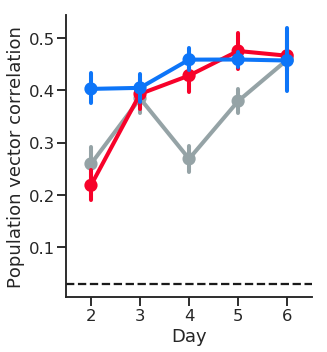

In [8]:
fig = plt.figure(figsize=(6,5))

g = sns.catplot(x='day',y="value", hue='grp',
                kind="point",data=df,ci=68)

# axisjpegmadia
g.set(xlabel='Day', ylabel=key_label)
sns.despine()

# legend
g._legend.remove()

# shuffle
g.ax.axhline(df_shuffle.value.mean(), linestyle='--', color='k')

# save
#g.savefig('figs/popvec-by-day-dpair.svg')

<Figure size 432x360 with 0 Axes>

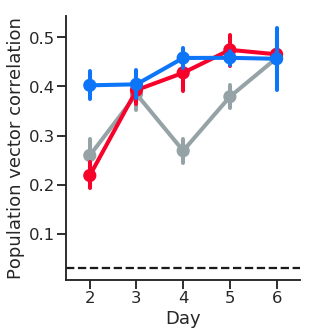

In [22]:
fig = plt.figure(figsize=(6,5))

g = sns.catplot(x='day',y="value", hue='grp',
                kind="point",data=df,ci=68)

# axisjpegmadia
g.set(xlabel='Day', ylabel=key_label)
sns.despine()

# legend
g._legend.remove()

# shuffle
g.ax.axhline(df_shuffle.value.mean(), linestyle='--', color='k')

# save
#g.savefig('figs/popvec-by-day-dpair.svg')

In [20]:
%%R -i df
library(nlme)

am2 <- with(df, lme(value ~ grp * day,random = ~1|mouseID))
print(anova(am2))
#summary(am2)

            numDF denDF  F-value p-value
(Intercept)     1   183 338.6233  <.0001
grp             2    13   1.0660  0.3726
day             4   183  16.8247  <.0001
grp:day         8   183   3.8676  0.0003


In [31]:
%%R -i df
am2 <-aov(value ~ (grp*day) + Error(mouseID/(day)), data = df)
print(summary(am2))



Error: mouseID
          Df Sum Sq Mean Sq F value Pr(>F)  
grp        2 0.2659 0.13297   6.546 0.0402 *
day        4 0.7340 0.18349   9.033 0.0165 *
grp:day    4 0.1990 0.04976   2.450 0.1762  
Residuals  5 0.1016 0.02031                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: mouseID:day
          Df Sum Sq Mean Sq F value   Pr(>F)    
day        4 0.6982 0.17456   9.262 1.25e-05 ***
grp:day    8 0.3237 0.04046   2.147   0.0491 *  
Residuals 48 0.9047 0.01885                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: Within
           Df Sum Sq  Mean Sq F value Pr(>F)
Residuals 135  1.017 0.007532               


In [20]:
for n,g in df.groupby("day"):
    
    print(n)
    g = just_day(g)
    stats.full_anova(g,ind_vars=['grp'],dep_var='value')

2
# Formula: value~C(grp)
# grp: set(['Control', 'CREB', 'dn-CREB'])

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.342   
Dependent Variable: value            AIC:                -64.2275
Date:               2020-01-07 12:37 BIC:                -58.9439
No. Observations:   43               Log-Likelihood:     35.114  
Df Model:           2                F-statistic:        11.94   
Df Residuals:       40               Prob (F-statistic): 8.61e-05
R-squared:          0.374            Scale:              0.012293
-----------------------------------------------------------------
                     Coef.  Std.Err.   t    P>|t|   [0.025 0.975]
-----------------------------------------------------------------
Intercept            0.2142   0.0261 8.1968 0.0000  0.1614 0.2670
C(grp)[T.Control]    0.0696   0.0395 1.7609 0.0859 -0.0103 0.1494
C(grp)[T.dn-CREB]    0.2070   0.0424 4.8796 0.0000  0.1213 0.2928
-----------------------

## ratio

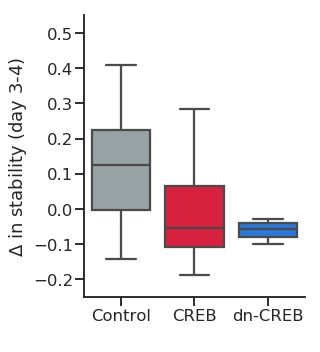

In [12]:
dfm = calc_day_diff(df_mid)

height,width = 5., 4.5

g = sns.catplot(x='grp',y="diff",
                kind="box",data=dfm,showfliers=False,
                height=height, aspect=width/height)

# axis
g.set(ylim=(-.25,.55),ylabel=r'$\Delta$ in stability (day 3-4)',xlabel=' ')
sns.despine()

# legend


# save
#g.savefig('figs/popvec-delta34-dpair-pcboth.svg')

In [240]:
stats.full_anova(dfm,ind_vars=['grp'],dep_var='diff')

# Formula: diff~C(grp)
# grp: set(['Control', 'CREB', 'dn-CREB'])

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.251   
Dependent Variable: diff             AIC:                -50.2061
Date:               2019-08-14 00:23 BIC:                -45.0653
No. Observations:   41               Log-Likelihood:     28.103  
Df Model:           2                F-statistic:        7.698   
Df Residuals:       38               Prob (F-statistic): 0.00156 
R-squared:          0.288            Scale:              0.016038
-----------------------------------------------------------------
                    Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
-----------------------------------------------------------------
Intercept          -0.0199   0.0317 -0.6287 0.5333 -0.0840 0.0442
C(grp)[T.Control]   0.1435   0.0473  3.0348 0.0043  0.0478 0.2392
C(grp)[T.dn-CREB]  -0.0438   0.0484 -0.9054 0.3710 -0.1417 0.0541
--------------------------

##  same v diff (supplement)

                index  position_bin_index  value  grp  pairing  trial_id  \
day reward_loc                                                             
2   Same           43                  43     43   43       43        43   
3   Same           43                  43     43   43       43        43   
4   Different      44                  44     44   44       44        44   
5   Same           41                  41     41   41       41        41   
6   Same           39                  39     39   39       39        39   

                condition  session  experimentType  startTime  mouseID  \
day reward_loc                                                           
2   Same               43       43              43         43       43   
3   Same               43       43              43         43       43   
4   Different          44       44              44         44       44   
5   Same               41       41              41         41       41   
6   Same               

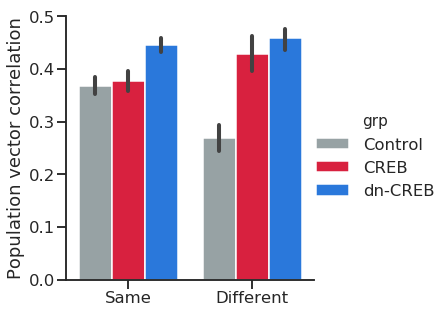

In [82]:
df = add_same_diff_cols(df)

ax = sns.catplot(x='reward_loc',y="value", hue='grp',
                kind="bar",data=df,ci=68)
    
ax.set(xlabel='', ylabel=key_label)
sns.despine()

In [83]:
%%R -i df
am2 <-aov(value ~ grp*reward_loc, data = df)

print(summary(am2))
#TukeyHSD(am2)

                Df Sum Sq Mean Sq F value   Pr(>F)    
grp              2  0.336 0.16788  10.223 5.87e-05 ***
reward_loc       1  0.003 0.00319   0.195   0.6596    
grp:reward_loc   2  0.140 0.07023   4.277   0.0152 *  
Residuals      204  3.350 0.01642                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = value ~ grp * reward_loc, data = df)

$grp
                      diff         lwr        upr     p adj
CREB-Control    0.03980368 -0.01009941 0.08970676 0.1461648
dn-CREB-Control 0.10121008  0.04808282 0.15433733 0.0000342
dn-CREB-CREB    0.06140640  0.01021473 0.11259808 0.0140351

$reward_loc
                      diff         lwr        upr    p adj
Same-Different 0.009580333 -0.03326179 0.05242246 0.659751

$`grp:reward_loc`
                                            diff           lwr        upr
CREB:Different-Control:Different     0.158938893  0.0240

In [99]:
for n,g in df.groupby("reward_loc"):
    
    print('**************{}***************'.format(n))
    print('')
    g = just_day(g)
    stats.full_anova(g, ind_vars=['grp','reward_loc'], dep_var='value')
    print('')

**************Different***************

# Formula: value~C(grp)
# grp: set(['Control', 'CREB', 'dn-CREB'])

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.329   
Dependent Variable: value            AIC:                -64.4669
Date:               2019-08-13 12:05 BIC:                -59.1143
No. Observations:   44               Log-Likelihood:     35.233  
Df Model:           2                F-statistic:        11.56   
Df Residuals:       41               Prob (F-statistic): 0.000104
R-squared:          0.361            Scale:              0.012667
-----------------------------------------------------------------
                   Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.4278   0.0281 15.2055 0.0000  0.3710  0.4847
C(grp)[T.Control] -0.1589   0.0412 -3.8589 0.0004 -0.2421 -0.0758
C(grp)[T.dn-CREB]  0.0303   0.0412  0.7365 0.4656 -

# Just 3 v 4 (probably don't need)

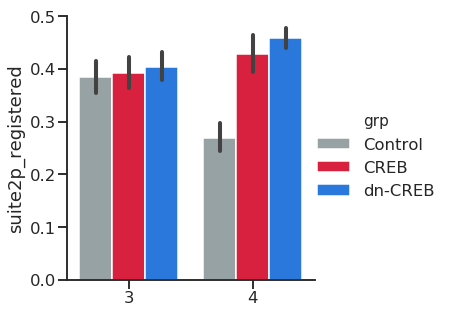

In [192]:
df_mid = just_day(df.loc[df["day"].isin(['3','4'])])

ax = sns.catplot(x='day',y="value", hue='grp',
                kind="bar",data=df_mid,ci=68)
    
ax.set(xlabel='', ylabel=label)
sns.despine()

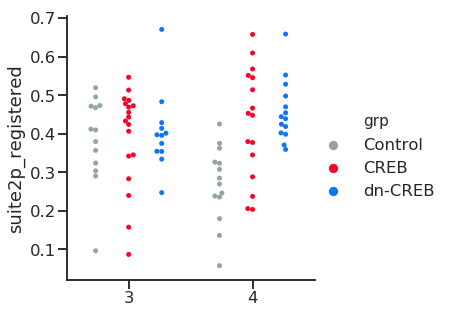

In [88]:
ax = sns.catplot(x='day',y="value", hue='grp',
                kind="swarm",dodge=True,data=df_mid,ci=68)
    
ax.set(xlabel='', ylabel=label)
sns.despine()

In [90]:
%%R -i df_mid
am2 <-aov(value ~ (grp*day) + Error(mouseID/(day)), data = df_mid)

#for label,df in all_dfs.items()
print(summary(am2))


Error: mouseID
          Df  Sum Sq Mean Sq F value Pr(>F)  
grp        2 0.17730 0.08865   4.007 0.0527 .
day        1 0.00557 0.00557   0.252 0.6267  
grp:day    2 0.26033 0.13016   5.883 0.0205 *
Residuals 10 0.22124 0.02212                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: mouseID:day
          Df Sum Sq Mean Sq F value Pr(>F)  
day        1 0.0017 0.00170   0.193 0.6681  
grp:day    2 0.1082 0.05409   6.131 0.0146 *
Residuals 12 0.1059 0.00882                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: Within
          Df Sum Sq  Mean Sq F value Pr(>F)
Residuals 56 0.4801 0.008574               


# PF correlation

## key select

In [27]:
key = 'pf_correlation'
key_label = 'Place field correlation'

# select key
df = deepcopy(all_dfs[key])
df,df_shuffle = just_day(df,shuffle=True)

# just day 3/4
df_mid = just_day(df.loc[df["day"].isin(['3','4'])])


## overall

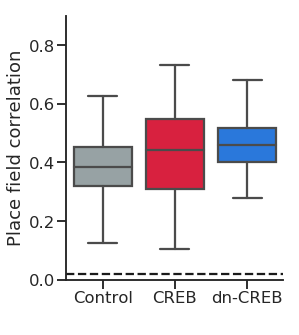

In [317]:
height,width = 5., 4.5
#fig = plt.figure(figsize=(2,5))
#ax = sns.boxplot(x="grp",y="value",data=df,showfliers=False)

g = sns.catplot(x='grp',y="value",
                kind="box",data=df,showfliers=False,
                height=height, aspect=width/height)

# axis
g.set(ylim=(0,.9),ylabel=key_label,xlabel=' ')
sns.despine()

# legend


# shuffle
g.ax.axhline(df_shuffle.value.mean(), linestyle='--', color='k')

# save
#g.savefig('figs/pfcorr-overall-dpair-pcboth.svg')

In [28]:
%%R -i df
am2 <-aov(value ~ grp, data = df)

print(summary(am2))
TukeyHSD(am2)

             Df Sum Sq Mean Sq F value  Pr(>F)   
grp           2  0.205 0.10230   5.152 0.00655 **
Residuals   208  4.130 0.01986                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = value ~ grp, data = df)

$grp
                      diff         lwr        upr     p adj
CREB-Control    0.04334619 -0.01151867 0.09821105 0.1515123
dn-CREB-Control 0.07881376  0.02064714 0.13698037 0.0045344
dn-CREB-CREB    0.03546757 -0.02056179 0.09149692 0.2957322



In [280]:
%%R -i df
am2 <-aov(value ~ grp, data = df)

print(summary(am2))
TukeyHSD(am2)

             Df Sum Sq Mean Sq F value  Pr(>F)   
grp           2  0.244  0.1218   6.481 0.00186 **
Residuals   207  3.891  0.0188                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = value ~ grp, data = df)

$grp
                      diff         lwr        upr     p adj
CREB-Control    0.04334619 -0.01003738 0.09672976 0.1364801
dn-CREB-Control 0.08663707  0.02980446 0.14346968 0.0011604
dn-CREB-CREB    0.04329087 -0.01147115 0.09805290 0.1511681



In [281]:
stats.full_anova(df,ind_vars=['grp'],dep_var='value')

# Formula: value~C(grp)
# grp: set(['Control', 'CREB', 'dn-CREB'])

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.050    
Dependent Variable: value            AIC:                -235.6277
Date:               2019-08-14 17:08 BIC:                -225.5863
No. Observations:   210              Log-Likelihood:     120.81   
Df Model:           2                F-statistic:        6.481    
Df Residuals:       207              Prob (F-statistic): 0.00186  
R-squared:          0.059            Scale:              0.018796 
------------------------------------------------------------------
                     Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
------------------------------------------------------------------
Intercept            0.4193   0.0153 27.3555 0.0000  0.3891 0.4495
C(grp)[T.Control]   -0.0433   0.0226 -1.9168 0.0566 -0.0879 0.0012
C(grp)[T.dn-CREB]    0.0433   0.0232  1.8662 0.0634 -0.0024 0.0890
-----------

## By day

## by day

<Figure size 432x360 with 0 Axes>

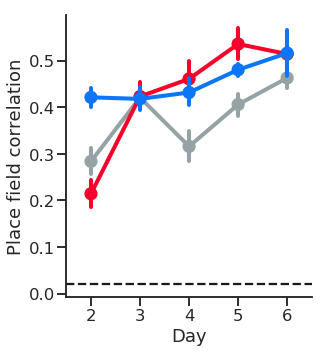

In [15]:
fig = plt.figure(figsize=(6,5))

g = sns.catplot(x='day',y="value", hue='grp',
                kind="point",data=df,ci=68)

# axisjpegmadia
g.set(xlabel='Day', ylabel=key_label)
sns.despine()

# legend
g._legend.remove()

# shuffle
g.ax.axhline(df_shuffle.value.mean(), linestyle='--', color='k')

# save
g.savefig('figs/pfcorr-by-day-dpair.svg')


#### two different stats approaches
Take a look at the two test below. nlme seems to agg by mouse, and aov lets session be present. dunno which is more valid, but probably going with aov

In [16]:
%%R -i df
library(nlme)

am2 <- with(df, lme(value ~ grp * day,random = ~1|mouseID))
print(anova(am2))
#summary(am2)

            numDF denDF   F-value p-value
(Intercept)     1   183 307.77148  <.0001
grp             2    13   0.49261   0.622
day             4   183  26.28233  <.0001
grp:day         8   183   4.56728  <.0001


In [17]:
%%R -i df
am2 <-aov(value ~ (grp*day) + Error(mouseID/(day)), data = df)
print(summary(am2))


Error: mouseID
          Df Sum Sq Mean Sq F value Pr(>F)  
grp        2 0.2046 0.10230   3.389 0.1174  
day        4 0.9874 0.24684   8.178 0.0203 *
grp:day    4 0.0822 0.02055   0.681 0.6345  
Residuals  5 0.1509 0.03018                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: mouseID:day
          Df Sum Sq Mean Sq F value   Pr(>F)    
day        4 0.9388 0.23470  17.834 4.93e-09 ***
grp:day    8 0.3219 0.04024   3.058  0.00731 ** 
Residuals 48 0.6317 0.01316                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: Within
           Df Sum Sq  Mean Sq F value Pr(>F)
Residuals 135  1.017 0.007533               


In [285]:
for n,g in df.groupby("day"):
    
    print(n)
    g = just_day(g)
    stats.full_anova(g,ind_vars=['grp'],dep_var='value')

2
# Formula: value~C(grp)
# grp: set(['Control', 'CREB', 'dn-CREB'])

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.342   
Dependent Variable: value            AIC:                -64.2275
Date:               2019-08-14 17:09 BIC:                -58.9439
No. Observations:   43               Log-Likelihood:     35.114  
Df Model:           2                F-statistic:        11.94   
Df Residuals:       40               Prob (F-statistic): 8.61e-05
R-squared:          0.374            Scale:              0.012293
-----------------------------------------------------------------
                     Coef.  Std.Err.   t    P>|t|   [0.025 0.975]
-----------------------------------------------------------------
Intercept            0.2142   0.0261 8.1968 0.0000  0.1614 0.2670
C(grp)[T.Control]    0.0696   0.0395 1.7609 0.0859 -0.0103 0.1494
C(grp)[T.dn-CREB]    0.2070   0.0424 4.8796 0.0000  0.1213 0.2928
-----------------------

## ratio

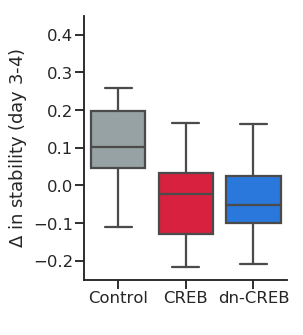

In [299]:
dfm = calc_day_diff(df_mid)

height,width = 5., 4.5

g = sns.catplot(x='grp',y="diff",
                kind="box",data=dfm,showfliers=False,
                height=height, aspect=width/height)

# axis
g.set(ylim=(-.25,.45),ylabel=r'$\Delta$ in stability (day 3-4)',xlabel=' ')
sns.despine()

# legend


# save
g.savefig('figs/pfcorr-delta34-dpair-pcboth.svg')

In [292]:
stats.full_anova(dfm,ind_vars=['grp'],dep_var='diff')

# Formula: diff~C(grp)
# grp: set(['Control', 'CREB', 'dn-CREB'])

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.167   
Dependent Variable: diff             AIC:                -52.9941
Date:               2019-08-14 17:13 BIC:                -47.8534
No. Observations:   41               Log-Likelihood:     29.497  
Df Model:           2                F-statistic:        5.002   
Df Residuals:       38               Prob (F-statistic): 0.0118  
R-squared:          0.208            Scale:              0.014984
-----------------------------------------------------------------
                    Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
-----------------------------------------------------------------
Intercept          -0.0227   0.0306 -0.7422 0.4625 -0.0847 0.0392
C(grp)[T.Control]   0.1218   0.0457  2.6657 0.0112  0.0293 0.2144
C(grp)[T.dn-CREB]  -0.0169   0.0467 -0.3617 0.7196 -0.1115 0.0777
--------------------------

##  same v diff (supplement)

                index  position_bin_index  value  grp  pairing  trial_id  \
day reward_loc                                                             
2   Same           43                  43     43   43       43        43   
3   Same           43                  43     43   43       43        43   
4   Different      44                  44     44   44       44        44   
5   Same           41                  41     41   41       41        41   
6   Same           39                  39     39   39       39        39   

                condition  session  experimentType  startTime  mouseID  \
day reward_loc                                                           
2   Same               43       43              43         43       43   
3   Same               43       43              43         43       43   
4   Different          44       44              44         44       44   
5   Same               41       41              41         41       41   
6   Same               

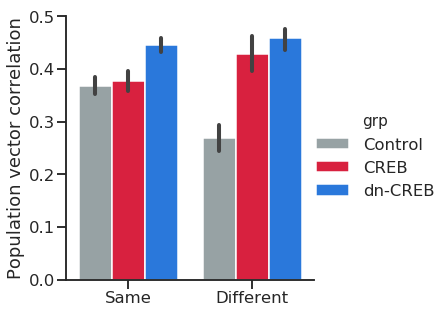

In [82]:
df_mid = just_day(df.loc[df["day"].isin(['3','4'])])
df = add_same_diff_cols(df)

ax = sns.catplot(x='reward_loc',y="value", hue='grp',
                kind="bar",data=df,ci=68)
    
ax.set(xlabel='', ylabel=key_label)
sns.despine()

In [83]:
%%R -i df
am2 <-aov(value ~ grp*reward_loc, data = df)

print(summary(am2))
#TukeyHSD(am2)

                Df Sum Sq Mean Sq F value   Pr(>F)    
grp              2  0.336 0.16788  10.223 5.87e-05 ***
reward_loc       1  0.003 0.00319   0.195   0.6596    
grp:reward_loc   2  0.140 0.07023   4.277   0.0152 *  
Residuals      204  3.350 0.01642                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = value ~ grp * reward_loc, data = df)

$grp
                      diff         lwr        upr     p adj
CREB-Control    0.03980368 -0.01009941 0.08970676 0.1461648
dn-CREB-Control 0.10121008  0.04808282 0.15433733 0.0000342
dn-CREB-CREB    0.06140640  0.01021473 0.11259808 0.0140351

$reward_loc
                      diff         lwr        upr    p adj
Same-Different 0.009580333 -0.03326179 0.05242246 0.659751

$`grp:reward_loc`
                                            diff           lwr        upr
CREB:Different-Control:Different     0.158938893  0.0240

In [99]:
for n,g in df.groupby("reward_loc"):
    
    print('**************{}***************'.format(n))
    print('')
    g = just_day(g)
    stats.full_anova(g, ind_vars=['grp','reward_loc'], dep_var='value')
    print('')

**************Different***************

# Formula: value~C(grp)
# grp: set(['Control', 'CREB', 'dn-CREB'])

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.329   
Dependent Variable: value            AIC:                -64.4669
Date:               2019-08-13 12:05 BIC:                -59.1143
No. Observations:   44               Log-Likelihood:     35.233  
Df Model:           2                F-statistic:        11.56   
Df Residuals:       41               Prob (F-statistic): 0.000104
R-squared:          0.361            Scale:              0.012667
-----------------------------------------------------------------
                   Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-----------------------------------------------------------------
Intercept          0.4278   0.0281 15.2055 0.0000  0.3710  0.4847
C(grp)[T.Control] -0.1589   0.0412 -3.8589 0.0004 -0.2421 -0.0758
C(grp)[T.dn-CREB]  0.0303   0.0412  0.7365 0.4656 -

# Reccurence prob

## key select

In [36]:
all_dfs.keys()

['recurrence', 'pf_correlation', 'pop_vector', 'centroid_shift']

In [10]:
key = 'recurrence'
key_label = 'Recurrence probability'

# select key
df = deepcopy(all_dfs[key])
df,df_shuffle = just_day(df,shuffle=True)

# just day 3/4
df_mid = just_day(df.loc[df["day"].isin(['3','4'])])


## overall

In [39]:
df.columns

Index([u'index', u'grp', u'num_pcs_first_expt', u'num_pcs_second_expt',
       u'num_recur', u'num_shared_rois', u'value', u'pairing', u'trial_id',
       u'condition', u'day', u'session', u'experimentType', u'startTime',
       u'mouseID', u'session_day'],
      dtype='object')

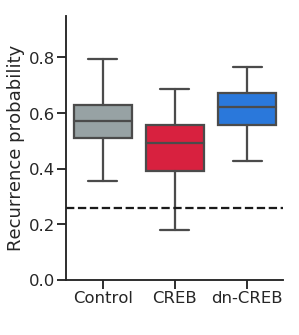

In [323]:
height,width = 5., 4.5
#fig = plt.figure(figsize=(2,5))
#ax = sns.boxplot(x="grp",y="value",data=df,showfliers=False)

g = sns.catplot(x='grp',y="value",
                kind="box",data=df,showfliers=False,
                height=height, aspect=width/height)

# axis
g.set(ylim=(0,.95),ylabel=key_label,xlabel=' ') # ylim=(0,.9)
sns.despine()

# legend


# shuffle
g.ax.axhline(df_shuffle.value.mean(), linestyle='--', color='k')

# save
#g.savefig('figs/recurr-overall-dpair-pcboth.svg')

In [320]:
%%R -i df
am2 <-aov(value ~ grp, data = df)

print(summary(am2))
TukeyHSD(am2)

             Df Sum Sq Mean Sq F value   Pr(>F)    
grp           2 0.6254 0.31268   22.77 1.14e-09 ***
Residuals   208 2.8566 0.01373                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = value ~ grp, data = df)

$grp
                       diff          lwr         upr     p adj
CREB-Control    -0.08132900 -0.126779696 -0.03587830 0.0001060
dn-CREB-Control  0.04953518  0.001125495  0.09794486 0.0435807
dn-CREB-CREB     0.13086417  0.084056149  0.17767220 0.0000000



In [321]:
stats.full_anova(df,ind_vars=['grp'],dep_var='value')

# Formula: value~C(grp)
# grp: set(['Control', 'CREB', 'dn-CREB'])

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.172    
Dependent Variable: value            AIC:                -302.9788
Date:               2019-08-15 20:10 BIC:                -292.9232
No. Observations:   211              Log-Likelihood:     154.49   
Df Model:           2                F-statistic:        22.77    
Df Residuals:       208              Prob (F-statistic): 1.14e-09 
R-squared:          0.180            Scale:              0.013734 
------------------------------------------------------------------
                      Coef.  Std.Err.    t    P>|t|  [0.025 0.975]
------------------------------------------------------------------
Intercept             0.4747   0.0131 36.2269 0.0000 0.4488 0.5005
C(grp)[T.Control]     0.0813   0.0193  4.2241 0.0000 0.0434 0.1193
C(grp)[T.dn-CREB]     0.1309   0.0198  6.5997 0.0000 0.0918 0.1700
-----------

## By day

<Figure size 432x360 with 0 Axes>

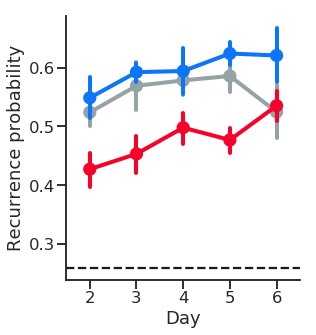

In [13]:
fig = plt.figure(figsize=(6,5))

g = sns.catplot(x='day',y="value", hue='grp',
                kind="point",data=df,ci=68)

# axisjpegmadia
g.set(xlabel='Day', ylabel=key_label)
sns.despine()

# legend
g._legend.remove()

# shuffle
g.ax.axhline(df_shuffle.value.mean(), linestyle='--', color='k')

# save
#g.savefig('figs/recurr-by-day-dpair.svg')

In [49]:
%%R -i df
am2 <-aov(value ~ (grp*day) + Error(mouseID/(day)), data = df)
print(summary(am2))


Error: mouseID
          Df Sum Sq Mean Sq F value Pr(>F)  
grp        2 0.5648 0.28241   9.422 0.0141 *
day        4 0.7222 0.18055   6.024 0.0270 *
grp:day    3 0.3237 0.10790   3.600 0.0852 .
Residuals  6 0.1798 0.02997                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: mouseID:day
          Df Sum Sq Mean Sq F value Pr(>F)  
day        4 0.1436 0.03589   2.689 0.0421 *
grp:day    8 0.0698 0.00872   0.653 0.7290  
Residuals 48 0.6407 0.01335                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: Within
           Df Sum Sq  Mean Sq F value Pr(>F)
Residuals 136  1.041 0.007652               


In [47]:
for n,g in df.groupby("day"):
    
    print(n)
    g = just_day(g)
    stats.full_anova(g,ind_vars=['grp'],dep_var='value')

2
# Formula: value~C(grp)
# grp: set(['Control', 'CREB', 'dn-CREB'])

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.153   
Dependent Variable: value            AIC:                -61.8811
Date:               2020-01-05 16:59 BIC:                -56.5975
No. Observations:   43               Log-Likelihood:     33.941  
Df Model:           2                F-statistic:        4.807   
Df Residuals:       40               Prob (F-statistic): 0.0135  
R-squared:          0.194            Scale:              0.012982
-----------------------------------------------------------------
                     Coef.  Std.Err.    t    P>|t|  [0.025 0.975]
-----------------------------------------------------------------
Intercept            0.4271   0.0269 15.9028 0.0000 0.3728 0.4814
C(grp)[T.Control]    0.0967   0.0406  2.3817 0.0221 0.0146 0.1788
C(grp)[T.dn-CREB]    0.1214   0.0436  2.7833 0.0082 0.0332 0.2095
-----------------------

In [285]:
for n,g in df.groupby("day"):
    
    print(n)
    g = just_day(g)
    stats.full_anova(g,ind_vars=['grp'],dep_var='value')

2
# Formula: value~C(grp)
# grp: set(['Control', 'CREB', 'dn-CREB'])

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.342   
Dependent Variable: value            AIC:                -64.2275
Date:               2019-08-14 17:09 BIC:                -58.9439
No. Observations:   43               Log-Likelihood:     35.114  
Df Model:           2                F-statistic:        11.94   
Df Residuals:       40               Prob (F-statistic): 8.61e-05
R-squared:          0.374            Scale:              0.012293
-----------------------------------------------------------------
                     Coef.  Std.Err.   t    P>|t|   [0.025 0.975]
-----------------------------------------------------------------
Intercept            0.2142   0.0261 8.1968 0.0000  0.1614 0.2670
C(grp)[T.Control]    0.0696   0.0395 1.7609 0.0859 -0.0103 0.1494
C(grp)[T.dn-CREB]    0.2070   0.0424 4.8796 0.0000  0.1213 0.2928
-----------------------

# Centroid shift

## key select

In [300]:
all_dfs.keys()

['recurrence', 'pf_correlation', 'pop_vector', 'centroid_shift']

In [312]:
key = 'centroid_shift'
key_label = 'Centroid shift (cm of belt)'

# select key
df = deepcopy(all_dfs[key])
df,df_shuffle = just_day(df,shuffle=True)

# just day 3/4
df_mid = just_day(df.loc[df["day"].isin(['3','4'])])


## overall

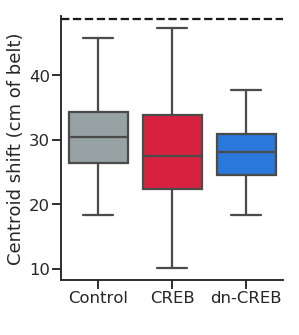

In [313]:
height,width = 5., 4.5
#fig = plt.figure(figsize=(2,5))
#ax = sns.boxplot(x="grp",y="value",data=df,showfliers=False)

g = sns.catplot(x='grp',y="value",
                kind="box",data=df,showfliers=False,
                height=height, aspect=width/height)

# axis
g.set(ylabel=key_label,xlabel=' ') # ylim=(0,.9)
sns.despine()

# legend


# shuffle
g.ax.axhline(df_shuffle.value.mean(), linestyle='--', color='k')

# save
g.savefig('figs/shift-overall-dpair-pcboth.svg')

In [307]:
%%R -i df
am2 <-aov(value ~ grp, data = df)

print(summary(am2))
TukeyHSD(am2)

             Df Sum Sq Mean Sq F value Pr(>F)  
grp           2    331  165.50   2.762 0.0655 .
Residuals   207  12404   59.92                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = value ~ grp, data = df)

$grp
                      diff       lwr       upr     p adj
CREB-Control    -2.1570463 -5.171221 0.8571288 0.2116715
dn-CREB-Control -3.0794251 -6.288342 0.1294916 0.0630341
dn-CREB-CREB    -0.9223789 -4.014385 2.1696277 0.7612658



In [308]:
stats.full_anova(df,ind_vars=['grp'],dep_var='value')

# Formula: value~C(grp)
# grp: set(['Control', 'CREB', 'dn-CREB'])

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.017    
Dependent Variable: value            AIC:                1458.4753
Date:               2019-08-15 10:15 BIC:                1468.5166
No. Observations:   210              Log-Likelihood:     -726.24  
Df Model:           2                F-statistic:        2.762    
Df Residuals:       207              Prob (F-statistic): 0.0655   
R-squared:          0.026            Scale:              59.923   
------------------------------------------------------------------
                    Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
------------------------------------------------------------------
Intercept          28.6979   0.8655 33.1587 0.0000 26.9916 30.4042
C(grp)[T.Control]   2.1570   1.2768  1.6894 0.0926 -0.3602  4.6743
C(grp)[T.dn-CREB]  -0.9224   1.3098 -0.7042 0.4821 -3.5046  1.6599
-----------

## By day

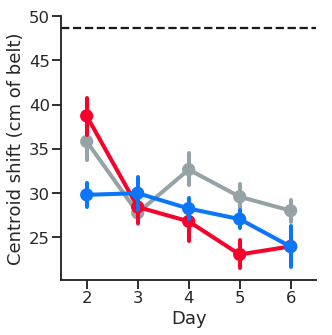

In [314]:
g = sns.catplot(x='day',y="value", hue='grp',
                kind="point",data=df,ci=68)

# axisjpegmadia
g.set(xlabel='Day', ylabel=key_label)
sns.despine()

# legend
g._legend.remove()

# shuffle
g.ax.axhline(df_shuffle.value.mean(), linestyle='--', color='k')

# save
g.savefig('figs/shift-by-day-dpair.svg')

In [310]:
%%R -i df
library(nlme)

am2 <- with(df, lme(value ~ grp * day,random = ~1|mouseID))
print(anova(am2))
#summary(am2)

            numDF denDF  F-value p-value
(Intercept)     1   182 743.5998  <.0001
grp             2    13   0.7698  0.4831
day             4   182  15.6018  <.0001
grp:day         8   182   2.7938  0.0061


In [311]:
for n,g in df.groupby("day"):
    
    print(n)
    g = just_day(g)
    stats.full_anova(g,ind_vars=['grp'],dep_var='value')

2
# Formula: value~C(grp)
# grp: set(['Control', 'CREB', 'dn-CREB'])

                  Results: Ordinary least squares
Model:               OLS              Adj. R-squared:     0.136   
Dependent Variable:  value            AIC:                303.4467
Date:                2019-08-15 10:15 BIC:                308.7303
No. Observations:    43               Log-Likelihood:     -148.72 
Df Model:            2                F-statistic:        4.302   
Df Residuals:        40               Prob (F-statistic): 0.0203  
R-squared:           0.177            Scale:              63.549  
------------------------------------------------------------------
                   Coef.  Std.Err.    t    P>|t|   [0.025   0.975]
------------------------------------------------------------------
Intercept         38.7302   1.8790 20.6126 0.0000  34.9327 42.5277
C(grp)[T.Control] -2.8941   2.8407 -1.0188 0.3144  -8.6354  2.8472
C(grp)[T.dn-CREB] -8.9303   3.0508 -2.9272 0.0056 -15.0963 -2.7643
---------

# Multi plot all measures

## overall

## by day, session and day

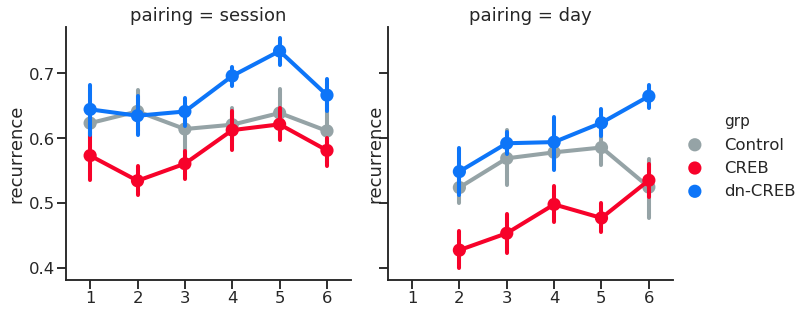

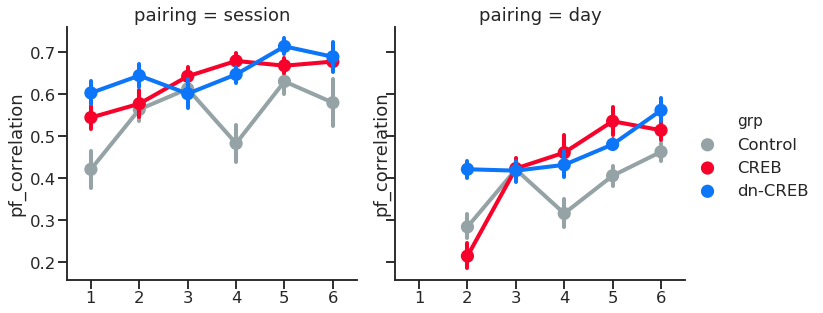

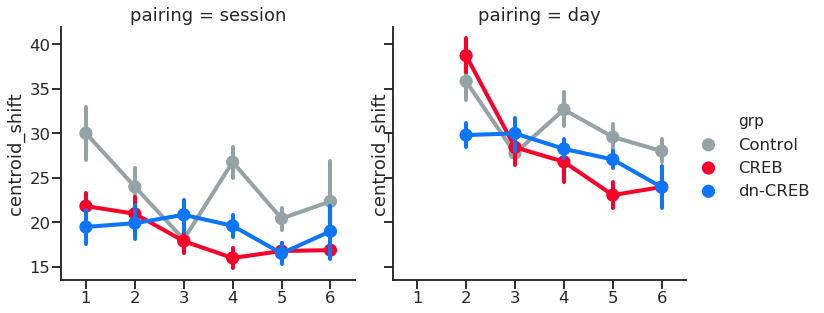

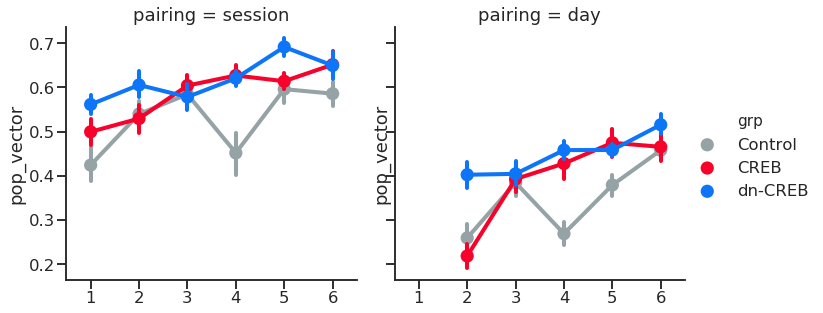

In [185]:
for label,df in all_dfs.items():

    ax = sns.catplot(x='day',col="pairing",y="value", hue='grp',
                kind="point",data=df[df.grp !='shuffle'],ci=68)

    ax.set(xlabel='', ylabel=label)
    sns.despine()

# 1st session effects

In [43]:
key = 'pf_correlation'
key_label = 'Population vector'

# select key
df = deepcopy(all_dfs_roi[key])
df,df_shuffle = just_session(df,shuffle=True)

[Text(0,0,'2_1'),
 Text(1,0,'3_1'),
 Text(2,0,'1_2'),
 Text(3,0,'2_2'),
 Text(4,0,'3_2'),
 Text(5,0,'1_3'),
 Text(6,0,'2_3'),
 Text(7,0,'3_3'),
 Text(8,0,'1_4'),
 Text(9,0,'2_4'),
 Text(10,0,'3_4'),
 Text(11,0,'1_5'),
 Text(12,0,'2_5'),
 Text(13,0,'3_5'),
 Text(14,0,'1_6'),
 Text(15,0,'2_6'),
 Text(16,0,'3_6')]

<Figure size 432x360 with 0 Axes>

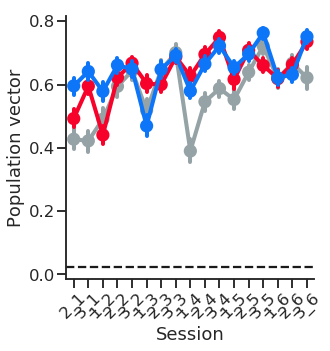

In [44]:
fig = plt.figure(figsize=(6,5))

g = sns.catplot(x='session_day',y="value", hue='grp',
                kind="point",data=df,ci=68)

# axisjpegmadia
g.set(xlabel='Session', ylabel=key_label)
sns.despine()

# legend
g._legend.remove()

# shuffle
g.ax.axhline(df_shuffle.value.mean(), linestyle='--', color='k')
g.ax.set_xticklabels(g.ax.get_xticklabels(),rotation=45)

In [45]:
df_filt = df.query("session_day=='2_1'")

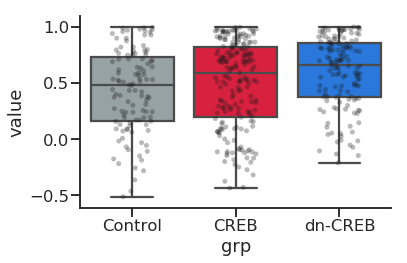

In [48]:
# make boxplot with Catplot
sns.catplot(x='grp', y='value', kind="box",  data=df_filt, height=4,aspect=1.5,showfliers=False)
# add data points to boxplot with stripplot
sns.stripplot(x='grp', y='value', data=df_filt, alpha=0.3,jitter=0.2,color='k')


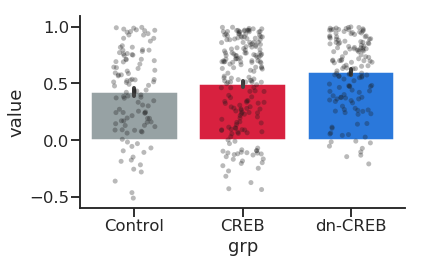

In [49]:
# make boxplot with Catplot
sns.catplot(x='grp', y='value', kind="bar",  data=df_filt, height=4,aspect=1.5,ci=68)
# add data points to boxplot with stripplot
sns.stripplot(x='grp', y='value', data=df_filt, alpha=0.3,jitter=0.2,color='k')


/home/matt/code/analysis/lab/mjd_scripts/helpers.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].astype("category")


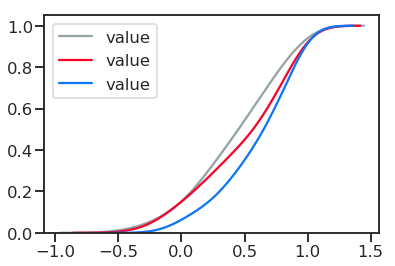

In [53]:
df_filt = mjdhelp.sort_df_by_group(df_filt)

# make boxplot with Catplot
for name, group in df_filt.groupby("grp"):
    sns.kdeplot(group.value, cumulative=True)



# All stats

In [10]:
# day stats 
for label,df in all_dfs.items():
    
    df = just_day(df)
    
    print(label)
    %Rpush df
    %R mixed_anova(df)

recurrence


            numDF denDF  F-value p-value
(Intercept)     1   183 589.3799  <.0001
grp             2    13   2.7661  0.0998
day             4   183   3.8792  0.0048
grp:day         8   183   1.1612  0.3250


pf_correlation


            numDF denDF  F-value p-value
(Intercept)     1   182 428.0442  <.0001
grp             2    13   1.1848  0.3368
day             4   182  30.5452  <.0001
grp:day         8   182   5.1508  <.0001


pop_vector


            numDF denDF  F-value p-value
(Intercept)     1   182 470.4005  <.0001
grp             2    13   2.8326  0.0953
day             4   182  23.5574  <.0001
grp:day         8   182   4.2163  0.0001


centroid_shift


            numDF denDF  F-value p-value
(Intercept)     1   182 743.5998  <.0001
grp             2    13   0.7698  0.4831
day             4   182  15.6018  <.0001
grp:day         8   182   2.7938  0.0061


In [199]:
# sessions stats
for label,df in all_dfs.items():

    df = just_session(df)
    
    print(label)
    %Rpush sdf
    %R mixed_anova(sdf)

recurrence


            numDF denDF   F-value p-value
(Intercept)     1   208 2049.5344  <.0001
grp             2    13    4.2284  0.0385
day             5   208    1.9526  0.0871
grp:day        10   208    0.4854  0.8984


pf_correlation


            numDF denDF   F-value p-value
(Intercept)     1   208 1273.6846  <.0001
grp             2    13    3.1589  0.0762
day             5   208    7.4444  <.0001
grp:day        10   208    2.1442  0.0226


centroid_shift


            numDF denDF  F-value p-value
(Intercept)     1   208 525.4645  <.0001
grp             2    13   3.1227  0.0781
day             5   208   2.9997  0.0123
grp:day        10   208   1.5016  0.1405


pop_vector


            numDF denDF   F-value p-value
(Intercept)     1   207 1084.8642  <.0001
grp             2    13    2.1856  0.1520
day             5   207    9.0618  <.0001
grp:day        10   207    2.4124  0.0098
